In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import urllib.request
import numpy as np
import colour 
import scipy.io
import time
from scipy.optimize import curve_fit

from colour.plotting import *
urllib.request.urlretrieve(
    "https://github.com/google/fonts/raw/main/ofl/ibmplexmono/IBMPlexMono-Regular.ttf",
    "IBMPlexMono-Regular.ttf",
)
fe = font_manager.FontEntry(fname="IBMPlexMono-Regular.ttf", name="plexmono")
font_manager.fontManager.ttflist.append(fe)
plt.rcParams.update(
    {
        "axes.facecolor": "#f5f4e9",
        "grid.color": "#AAAAAA",
        "axes.edgecolor": "#333333",
        "figure.facecolor": "#FFFFFF",
        "axes.grid": False,
        "axes.prop_cycle": plt.cycler("color", plt.cm.Dark2.colors),
        "font.family": fe.name,
        "figure.figsize": (3.5, 3.5 / 1.2),
        "ytick.left": True,
        "xtick.bottom": True,
    }
)

import random

np.random.seed(0)
random.seed(0)

In [2]:
mat = scipy.io.loadmat('./Data/NormFLEff.mat')

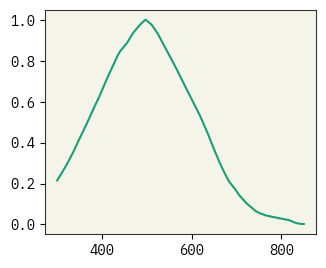

In [3]:
plt.plot(mat['FLEff'][:,0],mat['FLEff'][:,1])
plt.show()

In [4]:
# Load the FLEff data
FLEff = mat
FLEff = FLEff['FLEff']

# Directory listing and file range
files = sorted(os.listdir('./Data/proposed_trials/NLP'))
files = [file for file in files if ".txt" in file]



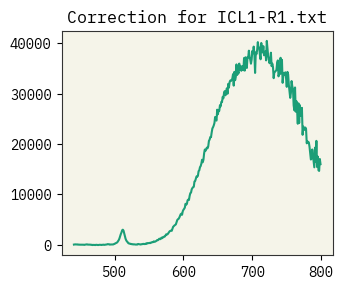

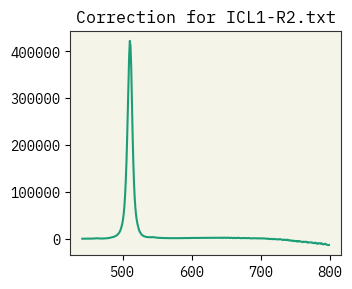

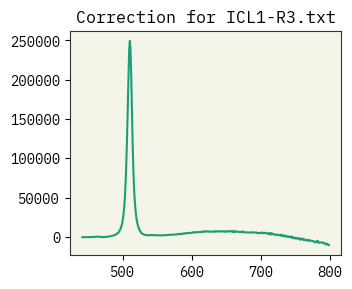

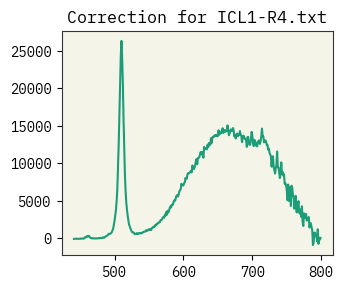

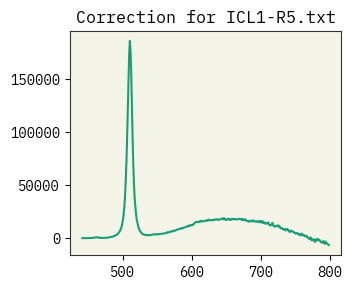

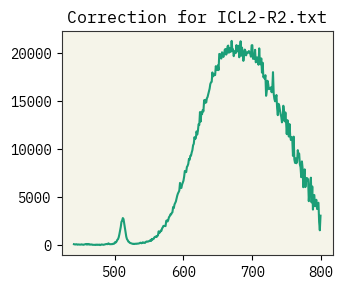

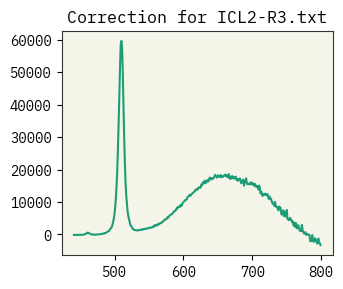

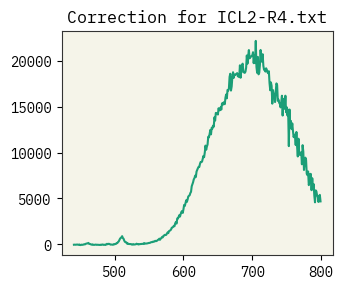

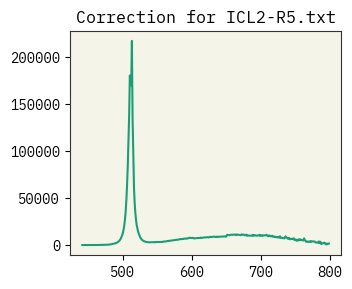

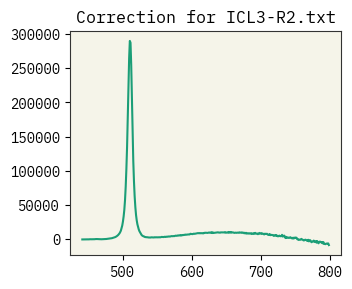

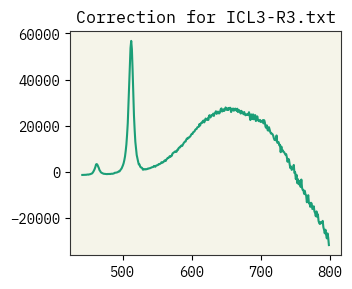

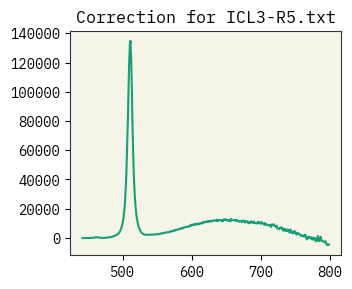

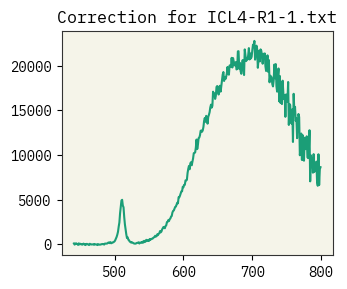

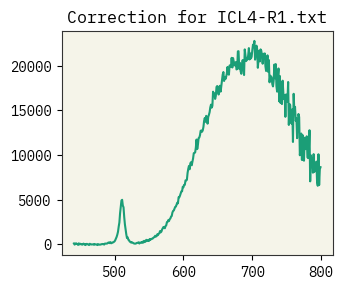

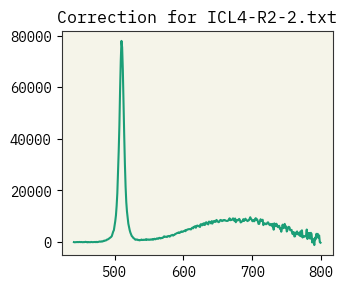

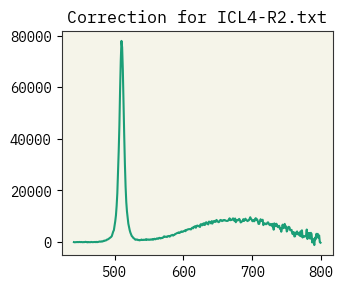

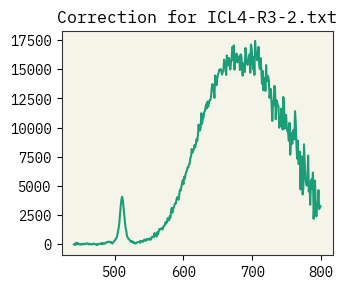

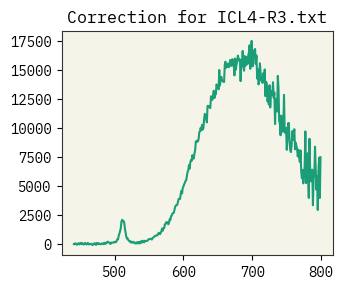

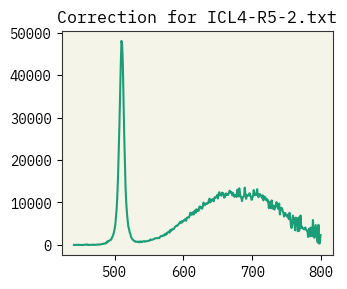

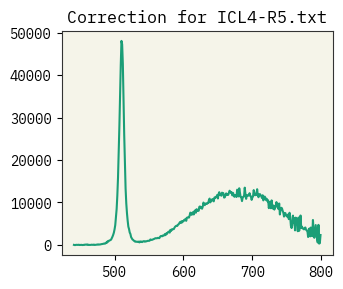

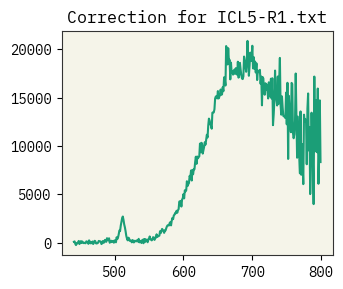

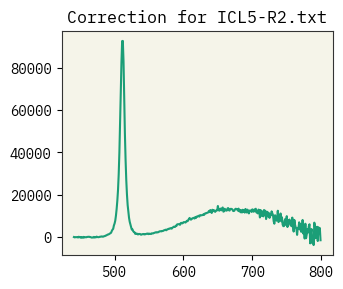

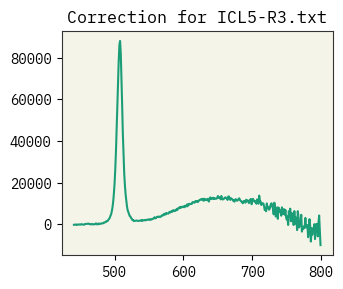

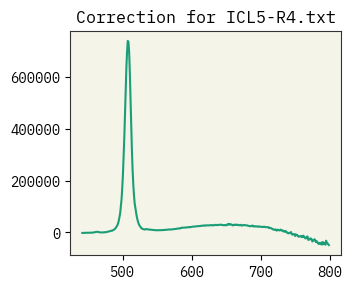

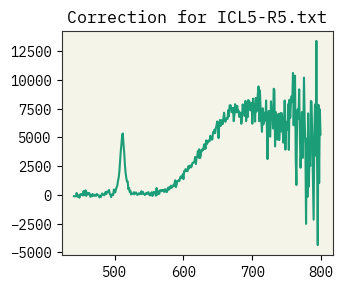

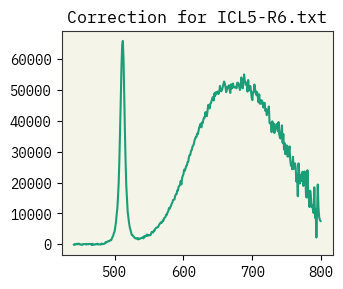

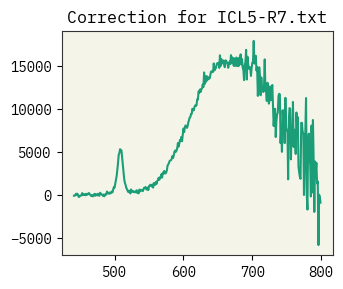

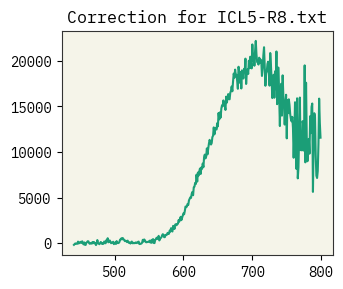

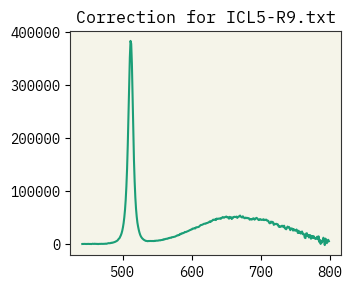

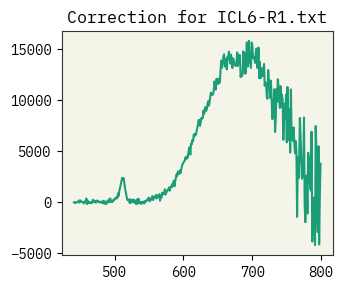

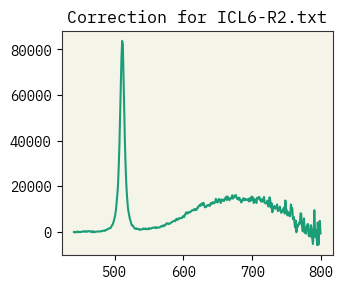

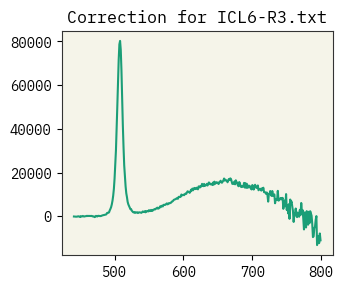

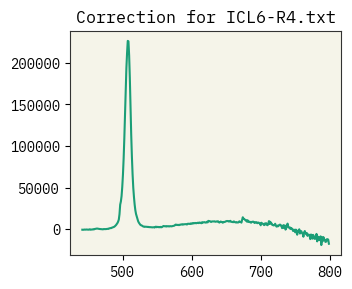

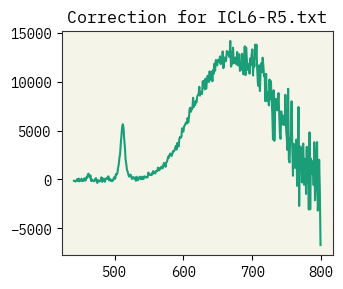

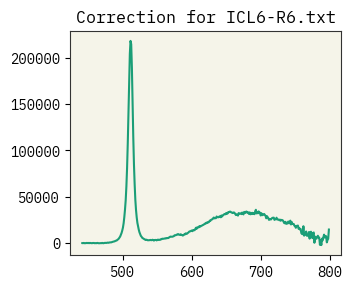

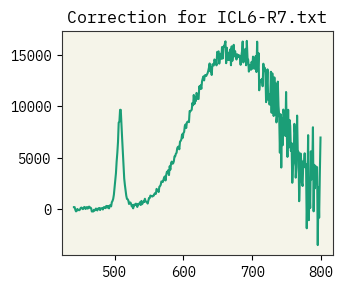

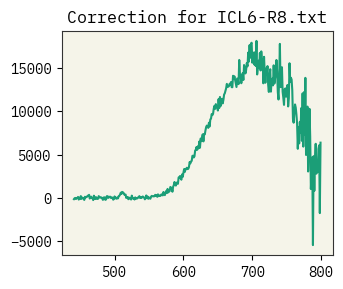

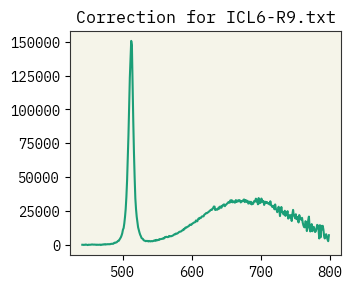

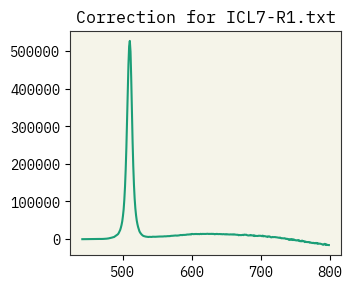

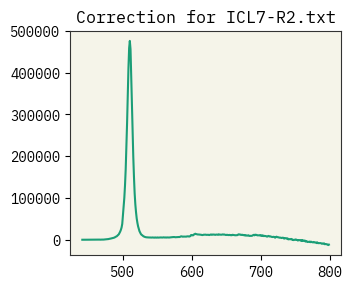

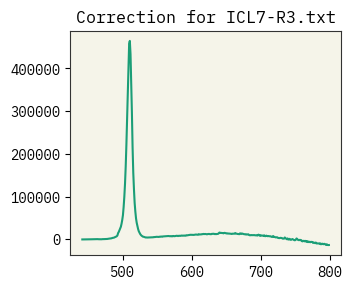

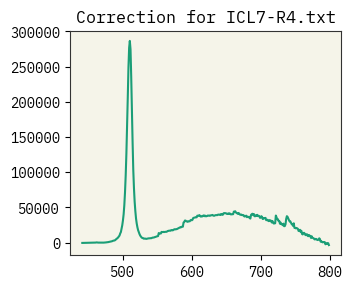

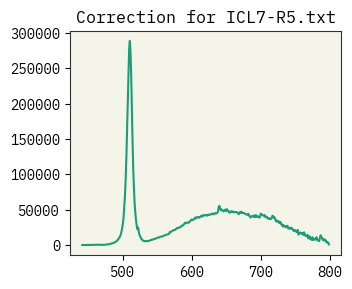

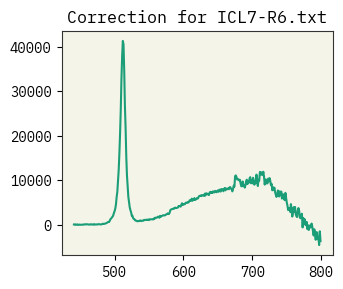

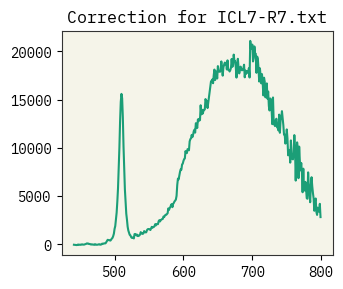

In [ ]:
import time
import numpy
# Start timing
start_time = time.time()
dirs= ["./Data/proposed_trials/NLP"]

# Loop over each file
for directory in dirs:
    # Get the list of files
    files = sorted(os.listdir(directory))
    files = [file for file in files if ("ICL" in file and "corrected" not in file and "csv" not in file)]
    GPk = np.ones(len(files))  # Set to 1 for single peak, modify as needed
    for ind in range(len(files)):
        # Clear variables
        EffS = EffE = Eff = S = None
        # Read the data
        path = directory + '/'
        tmp = pd.read_csv(path+files[ind], sep='\t').to_numpy()  # Adjust delimiter if needed
        WLS = tmp[:, 0]  # Wavelength data

        bkg = np.mean(tmp[:35, 1])  # Background calculation
        S = tmp[:, 1] - bkg  # Subtract background from signal

        # Apply efficiency curve
        EffS = np.where(FLEff[:, 0] == tmp[0, 0])[0][0]  # Start of Eff curve
        EffE = np.where(FLEff[:, 0] == tmp[-1, 0])[0][0]  # End of Eff curve
        Eff = FLEff[EffS:EffE+1, 1] 
        WLEff = FLEff[EffS:EffE+1, 0]  # Corrected wavelength array
        tmpC = S / Eff  # Apply efficiency correction
        # Fit range selection
        fitS = 441  # Start of fit range
        fitE = 800  # End of fit range
        i1 = np.where(WLS == fitS)[0][0]
        i2 = np.where(WLS == fitE)[0][0]
        tmpCF = tmpC[i1:i2]
        tmpWLF = WLS[i1:i2]
    
        # Gaussian fitting function
        def gauss1(x, a,b,c):
            return a/((2 * np.pi *c )**0.5) * np.exp(-((x - b) ** 2) / (2 * c ))
    
        def gauss2(x, a1, b1, c1, a2, b2, c2):
            return (a1 * np.exp(-((x - b1) ** 2) / (2 * c1 ** 2)) +
                    a2 * np.exp(-((x - b2) ** 2) / (2 * c2 ** 2)))
    
        # Perform the Gaussian fit
        plt.plot(tmpWLF, tmpCF, label='To Fit Range')
        plt.title(f'Correction for {files[ind]}')
        plt.show()
        flag = 0
        if GPk[ind] != 1:
            popt, _ = curve_fit(gauss1, tmpWLF, tmpCF, p0=[10000,680,3000])
            yFit = gauss1(np.arange(fitS, 1001), *popt)
        else:
            popt, _ = curve_fit(gauss2, tmpWLF, tmpCF,p0=[10000,511,1.5,100000,680,100])
            if popt[3] < 0:
                popt, _ = curve_fit(gauss1, tmpWLF, tmpCF, p0=[10000,511,1.5])
                flag = 1
        if flag == 1:
            yFit = gauss1(np.arange(fitS, 1001), *popt)
        else:
            yFit = gauss2(np.arange(fitS, 1001), *popt)
        # Plot corrected data and fit
        if flag == 1:
            plt.figure(1)
            plt.clf()
            plt.plot(WLS, tmpC, label='Corrected')
            plt.plot(tmpWLF, tmpCF, label='Fit Range')
            plt.plot(np.arange(fitS, 1001), yFit, label='Gaussian Fit')
            plt.title(f'Corrected Spectrum for {files[ind]}')
            plt.legend()
            plt.show()

        # Combine the corrected spectra
        WLFinal = np.arange(WLS[0], 1001)
        SFinal = tmpC
        #save the two columns WLC and yFit to a file
        name = files[ind].split('.')[:-1]
        name = '.'.join(name)
        np.savetxt(path+name+'_corrected.txt', np.column_stack((WLFinal, yFit)), delimiter='\t')
        #save the data to a file with the suffix _corrected
        if flag == 1:
            np.save(path+files[ind].split('.')[0]+'_corrected', SFinal[i1:len(WLFinal)])
            flag = 0


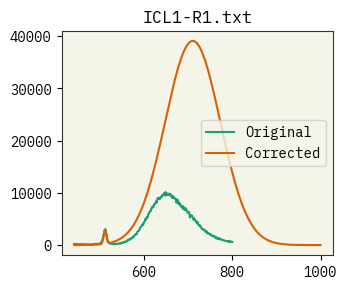

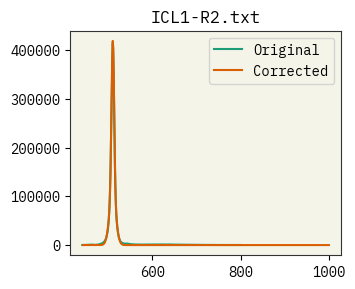

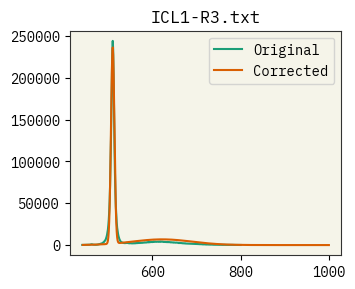

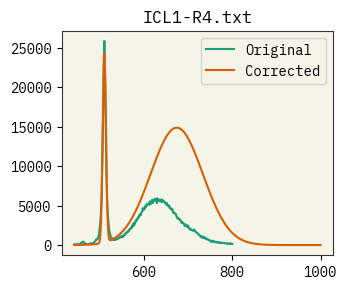

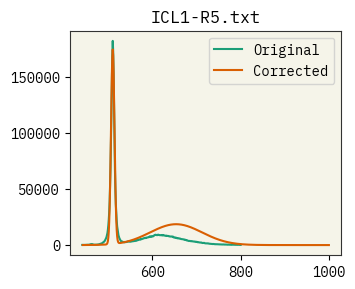

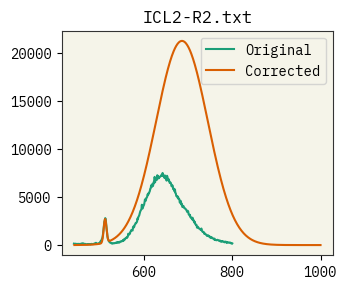

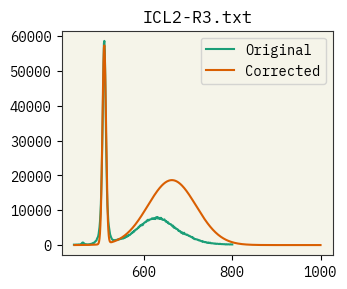

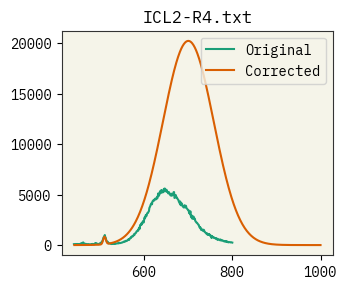

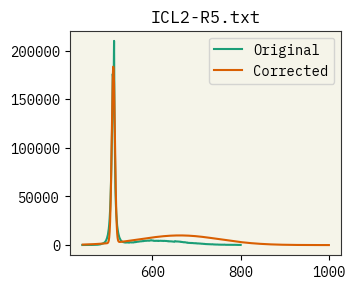

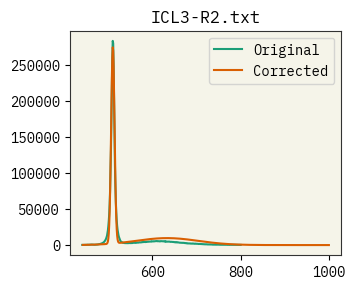

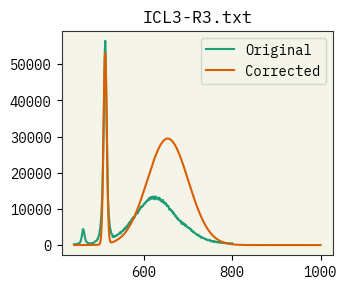

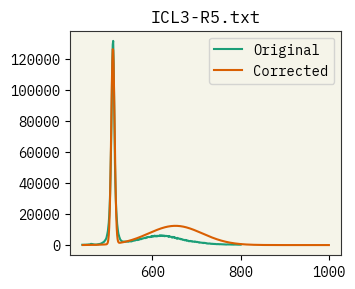

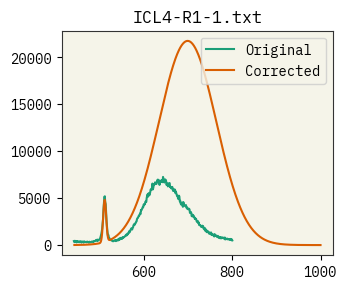

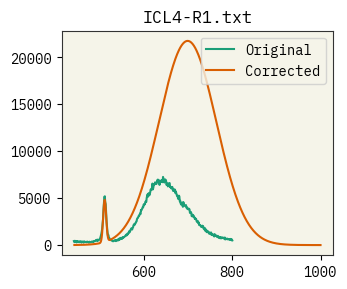

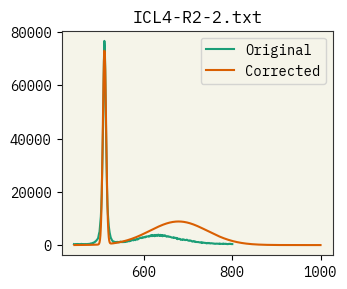

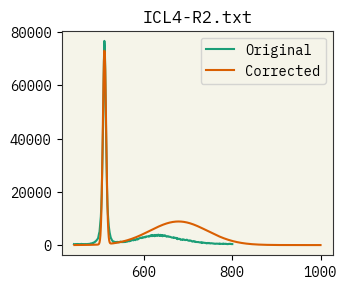

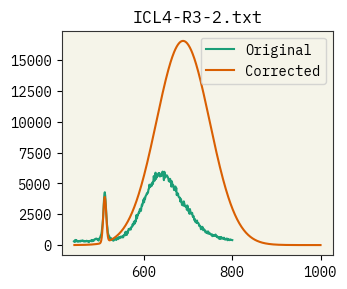

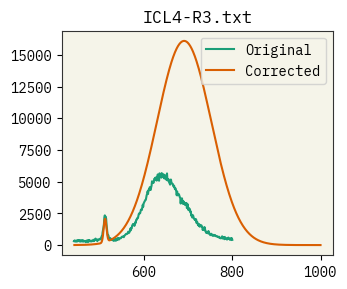

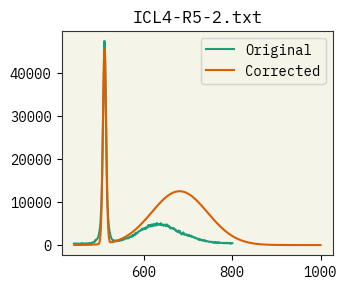

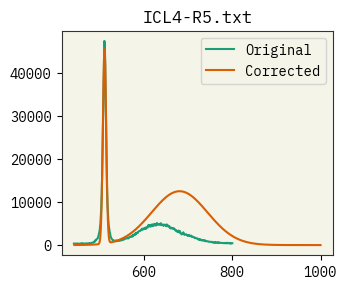

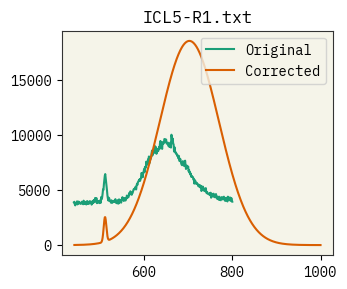

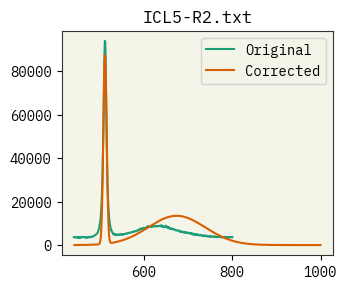

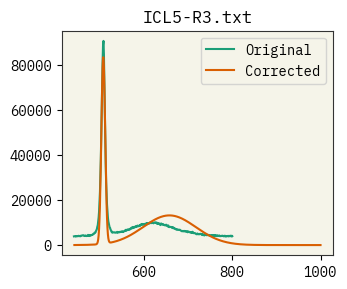

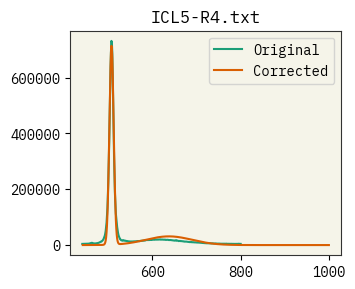

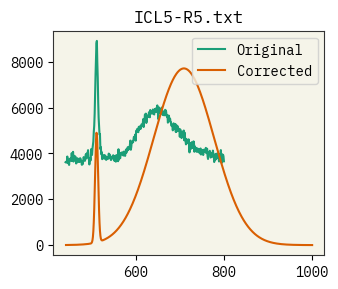

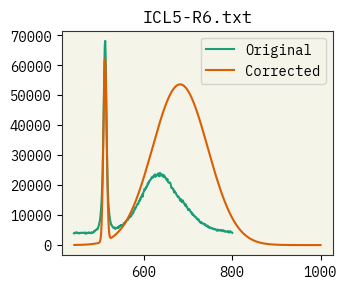

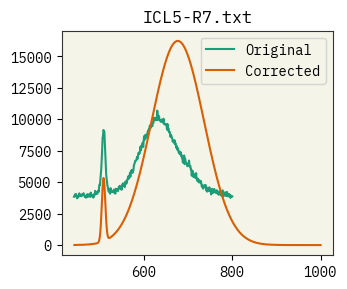

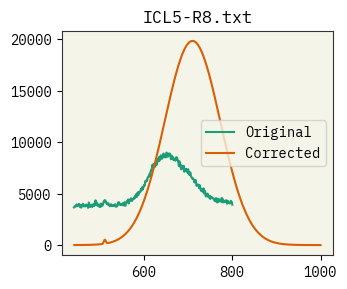

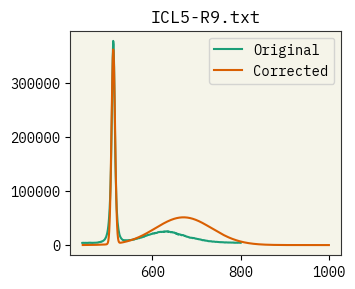

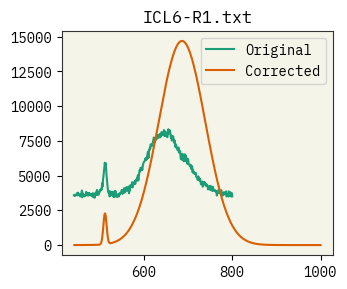

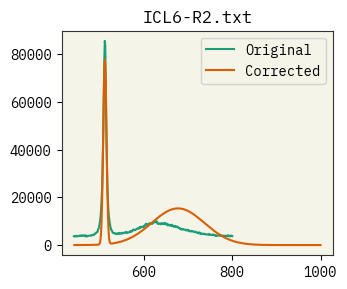

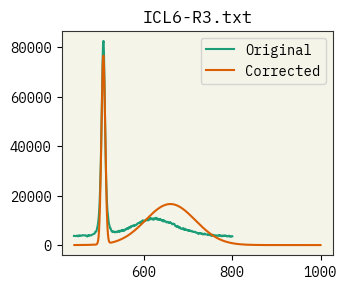

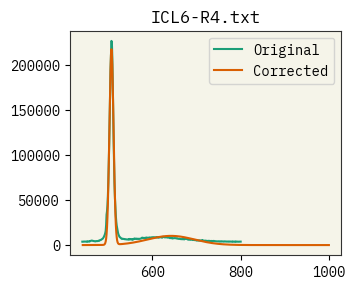

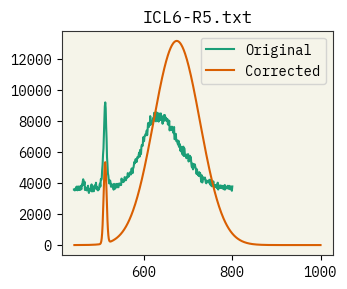

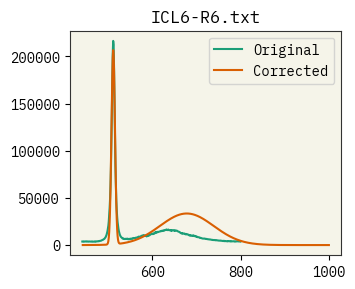

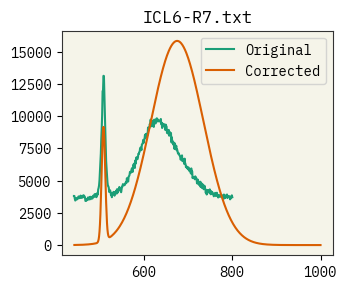

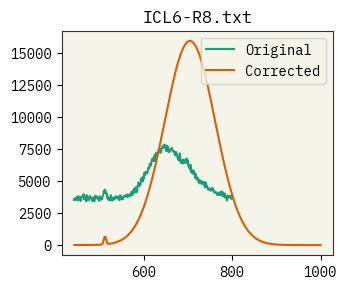

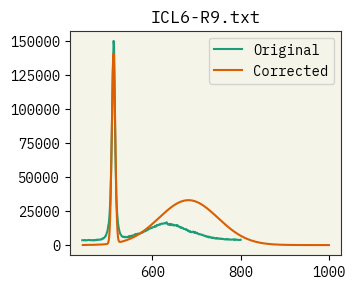

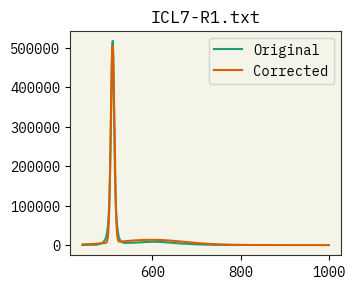

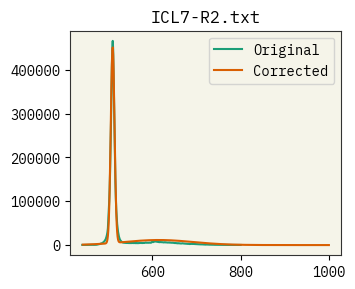

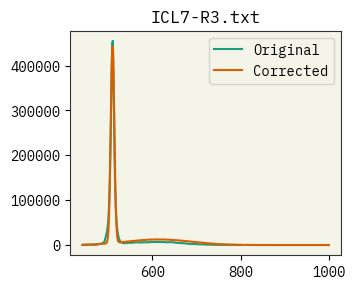

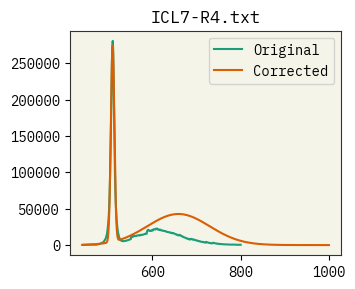

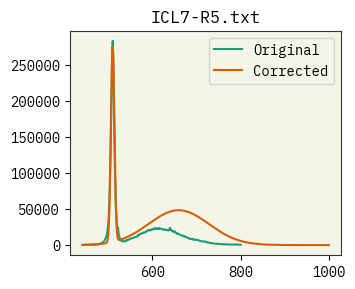

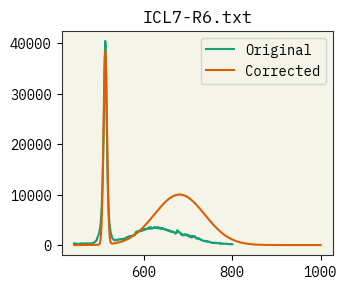

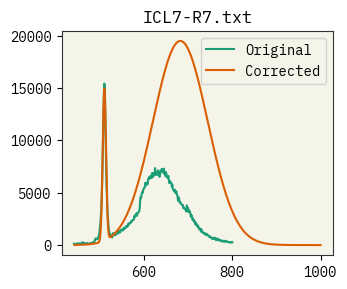

In [6]:
#plot the corrected data and the non correcte data 
directory = './Data/proposed_trials/NLP'
files = sorted(os.listdir(directory))
files = [file for file in files if ".txt" in file and "corrected" not in file]
files = [file for file in files if ".txt" in file and "_corrected" not in file]
for file in files:
    tmp = pd.read_csv(path+file, sep='\t').to_numpy()
    try:
        tmpC = pd.read_csv(path+file.split('.')[0]+'_corrected.txt', sep='\t').to_numpy()
    except:
        tmpC = pd.read_csv(path+file, sep='\t').to_numpy()
    plt.plot(tmp[:,0],tmp[:,1],label='Original')
    plt.plot(tmpC[:,0],tmpC[:,1],label='Corrected')
    plt.title(file)
    plt.legend()
    plt.show()
#make the same but for each directory, put them all in the same plot



## Util functions to process Spectre information

In [7]:
import numpy as np 
import pandas as pd
import os
# TODO: Refactor all these functions to take into account that we also have abs spectra now

def get_sd_object(wavelengths, intensities):

    assert len(wavelengths) == len(intensities)
    # Process fluorescence data
    spectral_df = {wavelengths[i]: intensities[i] for i in range(len(wavelengths))}
    # print(spectral_df)
    sd = colour.SpectralDistribution(spectral_df)
    return sd

def plot_spectra(sd,title=''):
    ax = plot_single_sd(
        sd,
        # title='Trial 16 \n QY:0.8 | AUC2: 0.82 | F:0.65',
        title=title,
        x_label='Wavelength (nm)',
        set_ylabel='Intensity',
    
    )
    
    # Customize the font size
    ax[1].set_xlabel('Wavelength (nm)', fontsize=14)
    ax[1].set_ylabel('Intensity', fontsize=18)
    ax[1].axvline(x=450, color='r', linestyle='--')
    ax[1].axvline(x=950, color='r', linestyle='--')
    # # 

def _get_peaks(x, y):
    peaks = []
    th = 0.001
    for i in range(1, len(x)-1):
        if y[i] > y[i-1]+th and y[i] > y[i+1]+th:
            peaks.append((x[i], y[i]))
    return peaks

def get_peaks(x, y):
    x = np.array(x)
    p1_i = np.where(x == 450)[0][0]
    p1_e = np.where(x == 550)[0][0]
    p2_i = np.where(x == 550)[0][0]
    p2_e = np.where(x == 950)[0][0]

    x1 = x[p1_i:p1_e]
    y1 = y[p1_i:p1_e]
    x2 = x[p2_i:p2_e]
    y2 = y[p2_i:p2_e]

    return x1[np.argmax(y1)], x2[np.argmax(y2)]

def get_area_under_peaks(x, y, norm=None):
    if not norm:
        return np.trapezoid(y, x)
    
    x = np.array(x)
    p1_i = np.where(x == 450)[0][0]
    p1_e = np.where(x == 530)[0][0]
    p2_i = np.where(x == 530)[0][0]
    p2_e = np.where(x == 950)[0][0]

    x1 = x[p1_i:p1_e]
    y1 = y[p1_i:p1_e]
    x2 = x[p2_i:p2_e]
    y2 = y[p2_i:p2_e]

    return np.trapezoid(y1, x1)/norm, np.trapezoid(y2, x2)/norm

def process_spectrum(x, y, norm_area):
    peaks = get_peaks(x, y)
    areas = get_area_under_peaks(x, y, norm_area)
    return peaks, areas

def smooth_spectrum(x, y, window=4):
    y = np.array(y)
    y_smooth = np.zeros_like(y)
    for i in range(len(y)):
        if i < window:
            y_smooth[i] = np.mean(y[:i+window])
        elif i > len(y) - window:
            y_smooth[i] = np.mean(y[i-window:])
        else:
            y_smooth[i] = np.mean(y[i-window:i+window])
    return x, y_smooth.tolist()

## Get f=AUC2*QY for new data

at 430nm 0.099194 absorbance at 430 ICL1-R1.csv ICL1-R1_corrected.txt


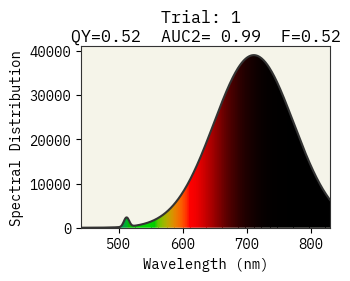

0.099194 absorbance at 430 ICL1-R1.csv ICL1-R1_corrected.txt
ICL1-R1_corrected.txt QY: 0.523703764079 AUC2: 0.994640053638 f: 0.520896739994
at 430nm 0.032618 absorbance at 430 ICL1-R2.csv ICL1-R2_corrected.txt


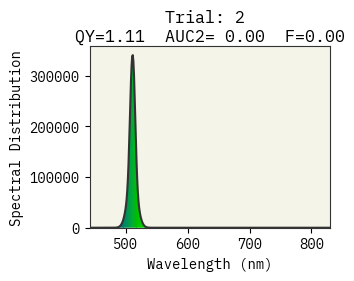

0.032618 absorbance at 430 ICL1-R2.csv ICL1-R2_corrected.txt
ICL1-R2_corrected.txt QY: 1.11157521625 AUC2: 0.00218437902708 f: 0.0024281015894
at 430nm 0.032145 absorbance at 430 ICL1-R3.csv ICL1-R3_corrected.txt


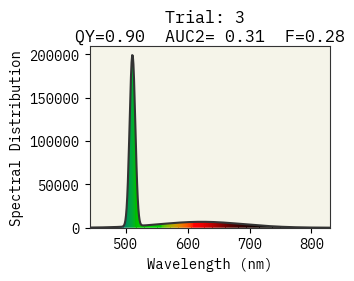

0.032145 absorbance at 430 ICL1-R3.csv ICL1-R3_corrected.txt
ICL1-R3_corrected.txt QY: 0.896171287596 AUC2: 0.311359926716 f: 0.279031826431
at 430nm 0.031933 absorbance at 430 ICL1-R4.csv ICL1-R4_corrected.txt


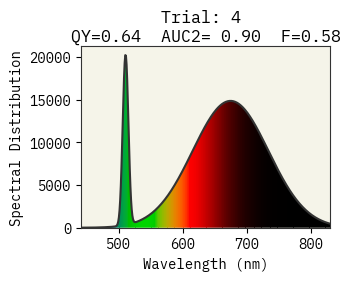

0.031933 absorbance at 430 ICL1-R4.csv ICL1-R4_corrected.txt
ICL1-R4_corrected.txt QY: 0.644282559157 AUC2: 0.903157927494 f: 0.581888900849
at 430nm 0.054685 absorbance at 430 ICL1-R5.csv ICL1-R5_corrected.txt


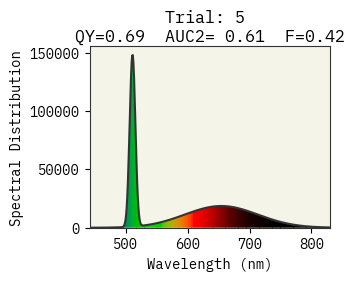

0.054685 absorbance at 430 ICL1-R5.csv ICL1-R5_corrected.txt
ICL1-R5_corrected.txt QY: 0.688475043541 AUC2: 0.608876333187 f: 0.419196160002
at 430nm 0.073134 absorbance at 430 ICL2-R2.csv ICL2-R2_corrected.txt


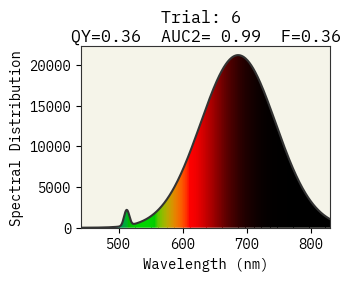

0.073134 absorbance at 430 ICL2-R2.csv ICL2-R2_corrected.txt
ICL2-R2_corrected.txt QY: 0.363440824462 AUC2: 0.990014250827 f: 0.35981159555
at 430nm 0.048788 absorbance at 430 ICL2-R3.csv ICL2-R3_corrected.txt


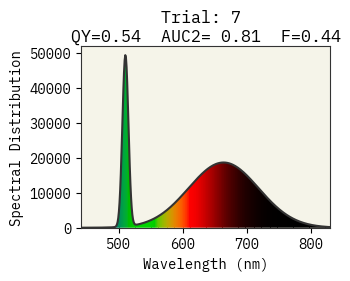

0.048788 absorbance at 430 ICL2-R3.csv ICL2-R3_corrected.txt
ICL2-R3_corrected.txt QY: 0.544249404785 AUC2: 0.810859530658 f: 0.441309816925
at 430nm 0.073674 absorbance at 430 ICL2-R4.csv ICL2-R4_corrected.txt


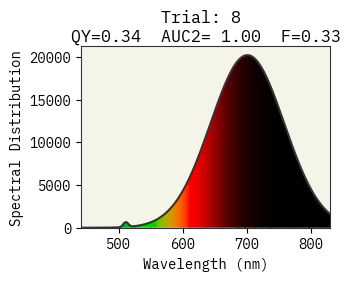

0.073674 absorbance at 430 ICL2-R4.csv ICL2-R4_corrected.txt
ICL2-R4_corrected.txt QY: 0.335377777219 AUC2: 0.996612340377 f: 0.334241631465
at 430nm 0.06625 absorbance at 430 ICL2-R5.csv ICL2-R5_corrected.txt


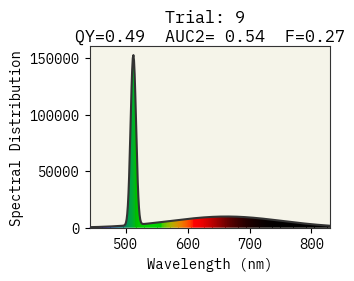

0.06625 absorbance at 430 ICL2-R5.csv ICL2-R5_corrected.txt
ICL2-R5_corrected.txt QY: 0.492495358838 AUC2: 0.540318640148 f: 0.266104422566
at 430nm 0.047895 absorbance at 430 ICL3-R2.csv ICL3-R2_corrected.txt


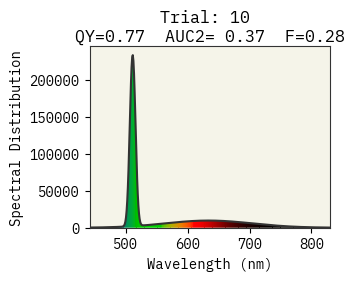

0.047895 absorbance at 430 ICL3-R2.csv ICL3-R2_corrected.txt
ICL3-R2_corrected.txt QY: 0.76594478174 AUC2: 0.367875227895 f: 0.281772111137
at 430nm 0.111063 absorbance at 430 ICL3-R3.csv ICL3-R3_corrected.txt


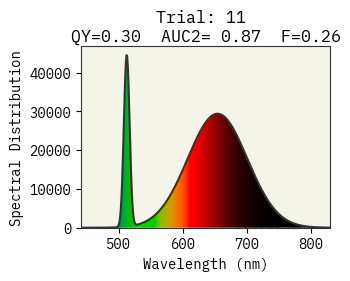

0.111063 absorbance at 430 ICL3-R3.csv ICL3-R3_corrected.txt
ICL3-R3_corrected.txt QY: 0.299918307755 AUC2: 0.871523401003 f: 0.261385823598
at 430nm 0.047993 absorbance at 430 ICL3-R5.csv ICL3-R5_corrected.txt


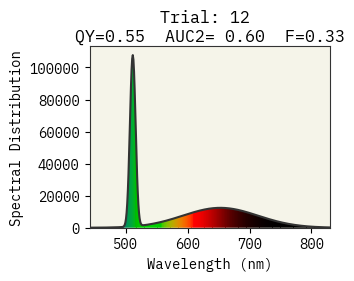

0.047993 absorbance at 430 ICL3-R5.csv ICL3-R5_corrected.txt
ICL3-R5_corrected.txt QY: 0.547981857353 AUC2: 0.597123455973 f: 0.327212820473
at 430nm 0.055494 absorbance at 430 ICL4-R1.csv ICL4-R1-1_corrected.txt


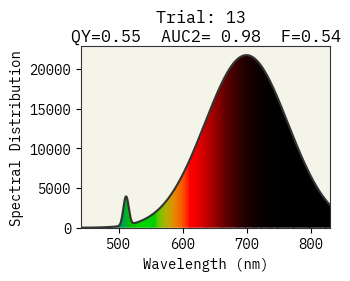

0.055494 absorbance at 430 ICL4-R1.csv ICL4-R1-1_corrected.txt
ICL4-R1-1_corrected.txt QY: 0.545769251118 AUC2: 0.984962336992 f: 0.537562157039
at 430nm 0.024912 absorbance at 430 ICL4-R2.csv ICL4-R1_corrected.txt


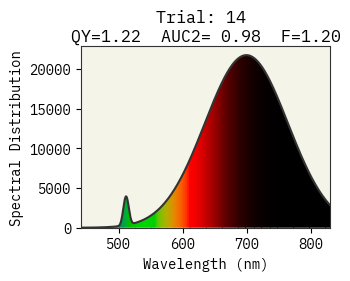

0.024912 absorbance at 430 ICL4-R2.csv ICL4-R1_corrected.txt
ICL4-R1_corrected.txt QY: 1.21575621474 AUC2: 0.984962336992 f: 1.19747408248
at 430nm 0.026988 absorbance at 430 ICL4-R3-2.csv ICL4-R2-2_corrected.txt


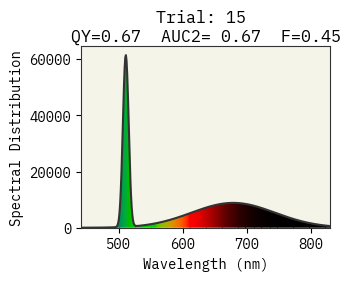

0.026988 absorbance at 430 ICL4-R3-2.csv ICL4-R2-2_corrected.txt
ICL4-R2-2_corrected.txt QY: 0.668769159967 AUC2: 0.671185095004 f: 0.448867892168
at 430nm 0.05988 absorbance at 430 ICL4-R3.csv ICL4-R2_corrected.txt


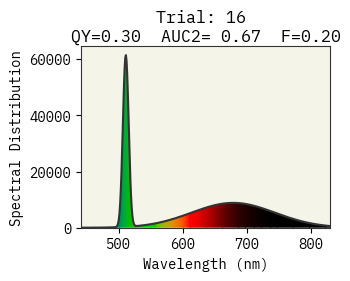

0.05988 absorbance at 430 ICL4-R3.csv ICL4-R2_corrected.txt
ICL4-R2_corrected.txt QY: 0.30141519855 AUC2: 0.671185095004 f: 0.202305388675
at 430nm 0.025624 absorbance at 430 ICL4-R5.csv ICL4-R3-2_corrected.txt


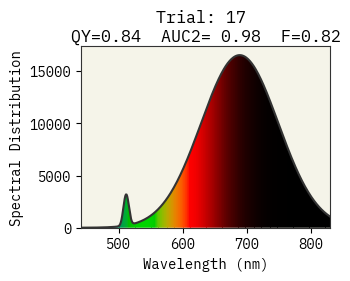

0.025624 absorbance at 430 ICL4-R5.csv ICL4-R3-2_corrected.txt
ICL4-R3-2_corrected.txt QY: 0.838232995476 AUC2: 0.98351993133 f: 0.824418858148
at 430nm 0.031878 absorbance at 430 ICL5-R1.csv ICL4-R3_corrected.txt


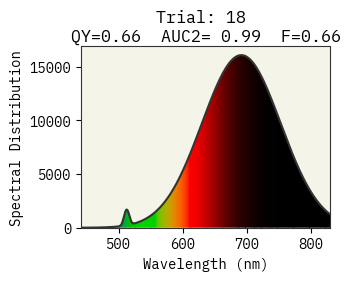

0.031878 absorbance at 430 ICL5-R1.csv ICL4-R3_corrected.txt
ICL4-R3_corrected.txt QY: 0.662894230961 AUC2: 0.989802502229 f: 0.656134368518
at 430nm 0.028792 absorbance at 430 ICL5-R2.csv ICL4-R5-2_corrected.txt


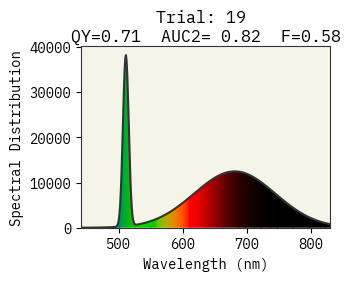

0.028792 absorbance at 430 ICL5-R2.csv ICL4-R5-2_corrected.txt
ICL4-R5-2_corrected.txt QY: 0.708270792369 AUC2: 0.817701732528 f: 0.57915425402
at 430nm 0.031612 absorbance at 430 ICL5-R3.csv ICL4-R5_corrected.txt


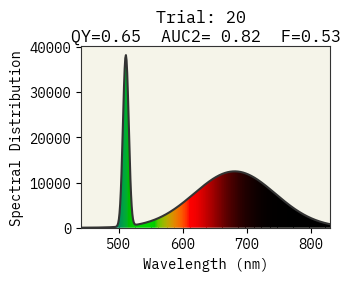

0.031612 absorbance at 430 ICL5-R3.csv ICL4-R5_corrected.txt
ICL4-R5_corrected.txt QY: 0.645088341576 AUC2: 0.817701732528 f: 0.52748985454
at 430nm 0.079609 absorbance at 430 ICL5-R4.csv ICL5-R1_corrected.txt


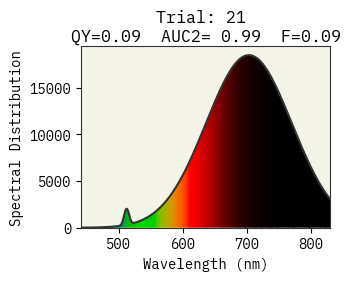

0.079609 absorbance at 430 ICL5-R4.csv ICL5-R1_corrected.txt
ICL5-R1_corrected.txt QY: 0.0876859620902 AUC2: 0.989765703118 f: 0.0867885579217
at 430nm 0.030959 absorbance at 430 ICL5-R5.csv ICL5-R2_corrected.txt


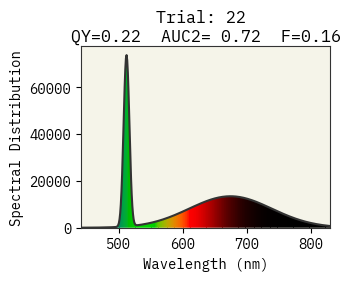

0.030959 absorbance at 430 ICL5-R5.csv ICL5-R2_corrected.txt
ICL5-R2_corrected.txt QY: 0.216029991321 AUC2: 0.718416958776 f: 0.155199609369
at 430nm 0.058546 absorbance at 430 ICL5-R6.csv ICL5-R3_corrected.txt


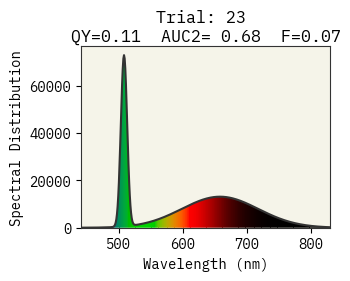

0.058546 absorbance at 430 ICL5-R6.csv ICL5-R3_corrected.txt
ICL5-R3_corrected.txt QY: 0.109036240054 AUC2: 0.678737445561 f: 0.0740069790475
at 430nm 0.033534 absorbance at 430 ICL5-R7.csv ICL5-R4_corrected.txt


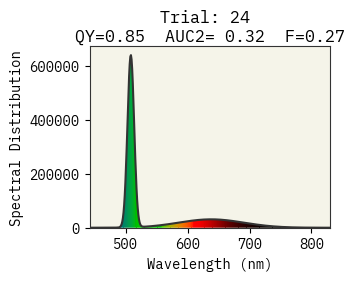

0.033534 absorbance at 430 ICL5-R7.csv ICL5-R4_corrected.txt
ICL5-R4_corrected.txt QY: 0.845827331139 AUC2: 0.31733929884 f: 0.268414252204
at 430nm 0.030517 absorbance at 430 ICL5-R8.csv ICL5-R5_corrected.txt


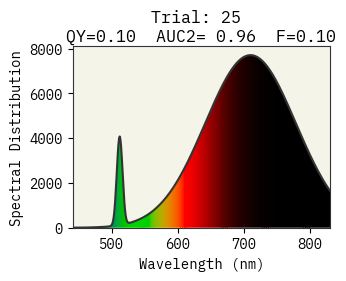

0.030517 absorbance at 430 ICL5-R8.csv ICL5-R5_corrected.txt
ICL5-R5_corrected.txt QY: 0.0999563995066 AUC2: 0.964662098137 f: 0.0964241500703
at 430nm 0.064265 absorbance at 430 ICL5-R9.csv ICL5-R6_corrected.txt


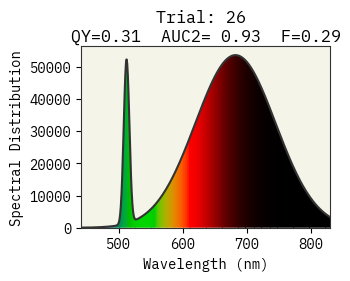

0.064265 absorbance at 430 ICL5-R9.csv ICL5-R6_corrected.txt
ICL5-R6_corrected.txt QY: 0.312316457359 AUC2: 0.930908052582 f: 0.290737905109
at 430nm 0.033054 absorbance at 430 ICL6-R1-T3.csv ICL5-R7_corrected.txt


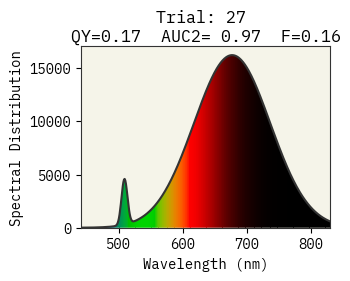

0.033054 absorbance at 430 ICL6-R1-T3.csv ICL5-R7_corrected.txt
ICL5-R7_corrected.txt QY: 0.167128132159 AUC2: 0.973411312772 f: 0.162684414526
at 430nm 0.029692 absorbance at 430 ICL6-R2-T3.csv ICL5-R8_corrected.txt


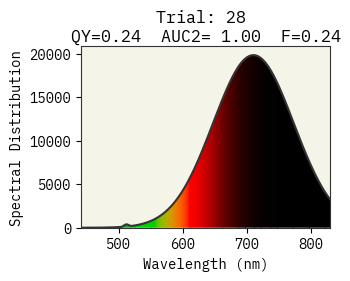

0.029692 absorbance at 430 ICL6-R2-T3.csv ICL5-R8_corrected.txt
ICL5-R8_corrected.txt QY: 0.236047594779 AUC2: 0.997169600149 f: 0.235379485702
at 430nm 0.036155 absorbance at 430 ICL6-R3-T3.csv ICL5-R9_corrected.txt


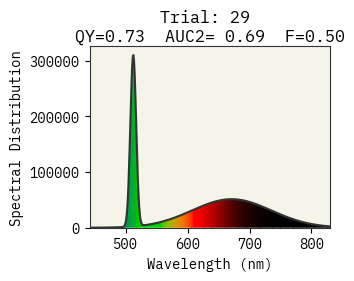

0.036155 absorbance at 430 ICL6-R3-T3.csv ICL5-R9_corrected.txt
ICL5-R9_corrected.txt QY: 0.730304682111 AUC2: 0.686815279375 f: 0.501584414273
at 430nm 0.077772 absorbance at 430 ICL6-R4-T3.csv ICL6-R1_corrected.txt


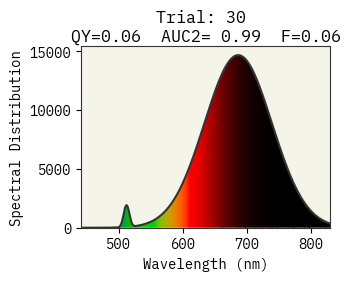

0.077772 absorbance at 430 ICL6-R4-T3.csv ICL6-R1_corrected.txt
ICL6-R1_corrected.txt QY: 0.0563168797426 AUC2: 0.988160436528 f: 0.0556501124704
at 430nm 0.029583 absorbance at 430 ICL6-R5-T3.csv ICL6-R2_corrected.txt


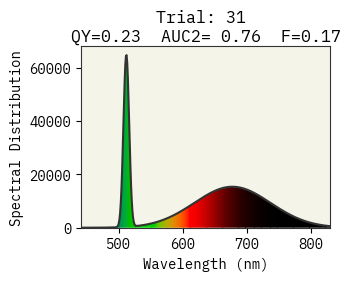

0.029583 absorbance at 430 ICL6-R5-T3.csv ICL6-R2_corrected.txt
ICL6-R2_corrected.txt QY: 0.227075252904 AUC2: 0.757725842987 f: 0.172060787428
at 430nm 0.067199 absorbance at 430 ICL6-R6-T3.csv ICL6-R3_corrected.txt


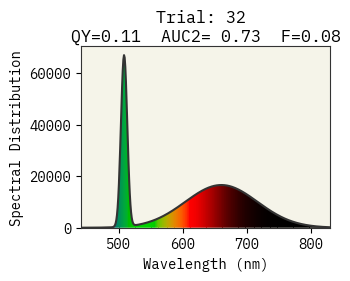

0.067199 absorbance at 430 ICL6-R6-T3.csv ICL6-R3_corrected.txt
ICL6-R3_corrected.txt QY: 0.10521807221 AUC2: 0.734698320018 f: 0.0773035408879
at 430nm 0.031566 absorbance at 430 ICL6-R7-T3.csv ICL6-R4_corrected.txt


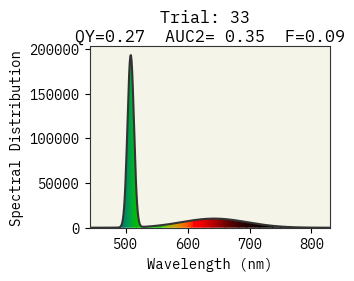

0.031566 absorbance at 430 ICL6-R7-T3.csv ICL6-R4_corrected.txt
ICL6-R4_corrected.txt QY: 0.274481420143 AUC2: 0.345640023018 f: 0.0948717643765
at 430nm 0.02583 absorbance at 430 ICL6-R8-T3.csv ICL6-R5_corrected.txt


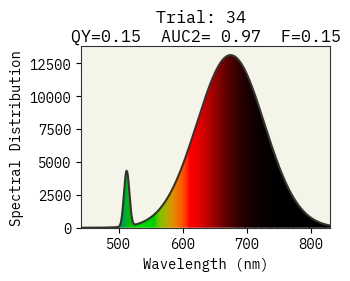

0.02583 absorbance at 430 ICL6-R8-T3.csv ICL6-R5_corrected.txt
ICL6-R5_corrected.txt QY: 0.153707990879 AUC2: 0.972413397879 f: 0.149467709692
at 430nm 0.067908 absorbance at 430 ICL6-R9-T3.csv ICL6-R6_corrected.txt


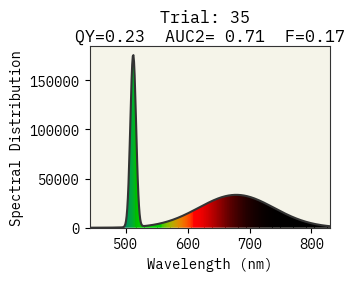

0.067908 absorbance at 430 ICL6-R9-T3.csv ICL6-R6_corrected.txt
ICL6-R6_corrected.txt QY: 0.234780431288 AUC2: 0.711385468947 f: 0.167019387212
at 430nm 0.046291 absorbance at 430 ICL7-R1.csv ICL6-R7_corrected.txt


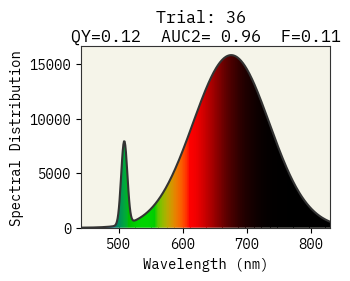

0.046291 absorbance at 430 ICL7-R1.csv ICL6-R7_corrected.txt
ICL6-R7_corrected.txt QY: 0.11860240705 AUC2: 0.955940379681 f: 0.113376830027
at 430nm 0.034711 absorbance at 430 ICL7-R2.csv ICL6-R8_corrected.txt


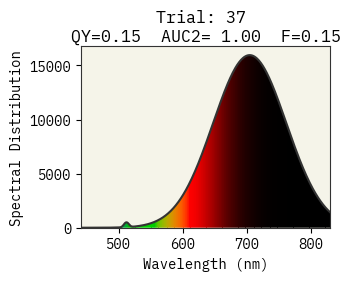

0.034711 absorbance at 430 ICL7-R2.csv ICL6-R8_corrected.txt
ICL6-R8_corrected.txt QY: 0.147645111013 AUC2: 0.997040655509 f: 0.147208178267
at 430nm 0.032434 absorbance at 430 ICL7-R3.csv ICL6-R9_corrected.txt


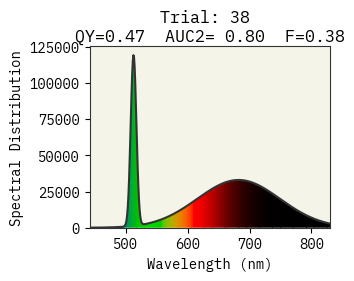

0.032434 absorbance at 430 ICL7-R3.csv ICL6-R9_corrected.txt
ICL6-R9_corrected.txt QY: 0.473121745934 AUC2: 0.795874856502 f: 0.376545701653
at 430nm 0.071816 absorbance at 430 ICL7-R4.csv ICL7-R1_corrected.txt


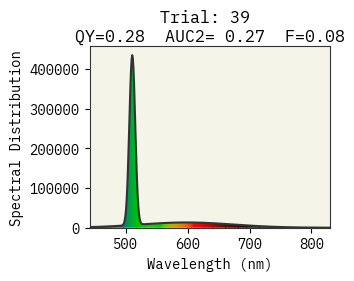

0.071816 absorbance at 430 ICL7-R4.csv ICL7-R1_corrected.txt
ICL7-R1_corrected.txt QY: 0.284611349519 AUC2: 0.274340453883 f: 0.0780804068074
at 430nm 0.064016 absorbance at 430 ICL7-R5.csv ICL7-R2_corrected.txt


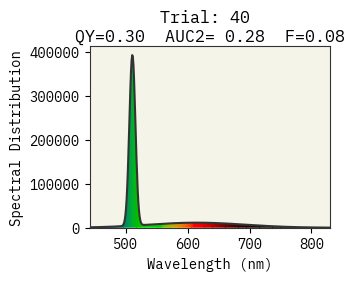

0.064016 absorbance at 430 ICL7-R5.csv ICL7-R2_corrected.txt
ICL7-R2_corrected.txt QY: 0.295378728402 AUC2: 0.278559361028 f: 0.0822805098451
at 430nm 0.032962 absorbance at 430 ICL7-R6.csv ICL7-R3_corrected.txt


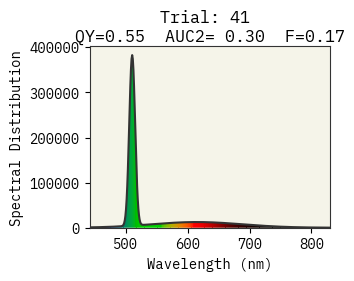

0.032962 absorbance at 430 ICL7-R6.csv ICL7-R3_corrected.txt
ICL7-R3_corrected.txt QY: 0.55409847274 AUC2: 0.301279437141 f: 0.166938475987
at 430nm 0.035529 absorbance at 430 ICL7-R7.csv ICL7-R4_corrected.txt


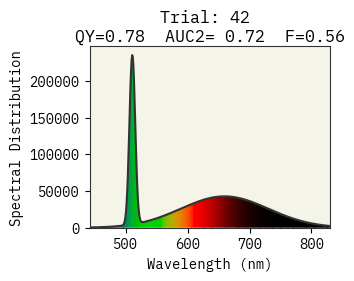

0.035529 absorbance at 430 ICL7-R7.csv ICL7-R4_corrected.txt
ICL7-R4_corrected.txt QY: 0.782023874691 AUC2: 0.715207483796 f: 0.559309327686
at 430nm 0.033562 absorbance at 430 ICL7-R8.csv ICL7-R5-4_corrected.txt


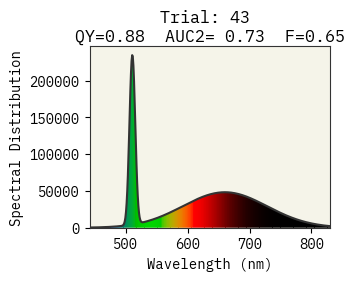

0.033562 absorbance at 430 ICL7-R8.csv ICL7-R5-4_corrected.txt
ICL7-R5-4_corrected.txt QY: 0.884101334974 AUC2: 0.734288217619 f: 0.649185193452


In [8]:
files = os.listdir('./Data/proposed_trials/NLP')
files_2 = os.listdir('./Data/proposed_trials/NLP')

txt_files = [file for file in files if file.endswith('.txt') and 'corrected' in file]
csv_files = [file for file in files_2 if file.endswith('.csv') ]
#organize them together such that the first .txt file corresponds to the first .csv file
txt_files.sort() #To make sure they are zipped in the right order correctly
csv_files.sort() #To make sure they are zipped in the right order correctly

for i, (txt, csv) in enumerate(zip(txt_files, csv_files)):
    try:
        with open(f"./Data/proposed_trials/NLP/{txt}", 'r',encoding='utf-8-sig') as input:
                    lines = input.readlines()
                    x = []
                    y = []
                    for line in lines:
                        x.append(float(line.split()[0]))
                        y.append(float(line.split()[1]))
                    y = [yi-min(y) for yi in y]
                    f_x, f_y = smooth_spectrum(x, y)
                    

                    fl_int_norm = [yi/max(f_y) for yi in f_y]
                    fl_auc_total = get_area_under_peaks(f_x, f_y)
                    peaks, areas = process_spectrum(f_x, f_y, norm_area=fl_auc_total)
                    fl_wvl, fl_int = f_x[:], f_y[:]
        if os.path.exists(f"./Data/proposed_trials/NLP/{csv}"):
                    df = pd.read_csv(f"./Data/proposed_trials/NLP/{csv}")
                    df.sort_values(by=['nm'], inplace=True) # wavelengths were saved in reversed order
                    x, y = df['nm'].astype(float).to_list(), df[' A'].astype(float).to_list()
                    x, y = smooth_spectrum(x, y)
                    #print absorption at 430nm
                    abs_int_norm = [yi/max(y) for yi in y]
                    print("at 430nm",df[df['nm'] == 430][' A'].values[0],"absorbance at 430", csv, txt)
                    abs_auc_total = get_area_under_peaks(x, y)
                    abs_wvl, abs_int = x[:], y[:]
                    # qy = qy_r * (fl_s/fl_r) * (abs_r/abs_s) * (n_s/n_r)**2 Constant values took from Farwa's spreadsheet
                    abs_s = df[df['nm'] == 430][' A'].values[0]
                    fl_r, abs_r, n_r = 8272505, 0.129734, 1.3611
                    if "ICL5" in txt or "ICL6" in txt:
                        fl_r, abs_r, n_r = 9453221.02, 0.039083, 1.3611
                    elif "ICL7" in txt:
                        fl_r, abs_r, n_r =  8930003.417, 0.044838, 1.3611
                    fl_s, abs_s, n_s = fl_auc_total, abs_s, 1.375
                    qy = 0.53 * (fl_auc_total/fl_r) * (abs_r/abs_s) * (n_s/n_r)**2
                    #two decimals
                    sd = get_sd_object(f_x, f_y)
                    _title = f"Trial: {i+1} \nQY={qy:.2f}  AUC2= {areas[1]:.2f}  F={qy*areas[1]:.2f}"
                    plot_spectra(sd,title = _title)#,fontsize=10)
                    plt.show()
                    print(abs_s,"absorbance at 430", csv, txt)
    except Exception as e:
           print(f"Exception at {txt} and {csv}")
           print(e)
           continue
    print(txt,"QY:",qy, "AUC2:", areas[1],"f:", qy*areas[1])

In [ ]:
import os
import matplotlib.pyplot as plt
files = os.listdir('./Data/proposed_trials/pre-doping/')
#split files in two lists, one .txt and one .csv
txt_files = [file for file in files if file.endswith('.txt')]
csv_files = [file for file in files if file.endswith('.csv')]
#organize them together such that the first .txt file corresponds to the first .csv file
txt_files.sort() #To make sure they are zipped in the right order correctly
csv_files.sort() #To make sure they are zipped in the right order correctly
for txt,csv in zip(txt_files,csv_files):
    print(txt,csv)

In [ ]:
#get list of files in Data/fluoressence_data starting in M

for i, (txt, csv) in enumerate(zip(txt_files, csv_files)):
    try:
        with open(f"Data/proposed_trials/pre-doping/{txt}", 'r',encoding='utf-8-sig') as input:
                    lines = input.readlines()
                    x = []
                    y = []
                    for line in lines:
                        x.append(float(line.split()[0]))
                        y.append(float(line.split()[1]))
                    y = [yi-min(y) for yi in y]
                    x, y = smooth_spectrum(x, y)
                    #plot_spectrum(x, y, txt)
                    plt.plot(x, y,color='C1')
                    plt.xlabel('Wavelength (nm)')
                    plt.ylabel('Fluorescense Intensity (counts)')

                    fl_int_norm = [yi/max(y) for yi in y]
                    fl_auc_total = get_area_under_peaks(x, y)
                    peaks, areas = process_spectrum(x, y, norm_area=fl_auc_total)
                    fl_wvl, fl_int = x[:], y[:]
        
        #if os.path.exists(f"Data/fluorescence_data/proposed_trials/NLP/{csv}"):
        if os.path.exists(f"Data/proposed_trials/pre-doping/{csv}"):
                    df = pd.read_csv(f"Data/proposed_trials/pre-doping/{csv}")
                    df.sort_values(by=['nm'], inplace=True) # wavelengths were saved in reversed order
                    x, y = df['nm'].astype(float).to_list(), df[' A'].astype(float).to_list()
                    x, y = smooth_spectrum(x, y)
                    abs_int_norm = [yi/max(y) for yi in y]
                    abs_auc_total = get_area_under_peaks(x, y)
                    abs_wvl, abs_int = x[:], y[:]
                    # qy = qy_r * (fl_s/fl_r) * (abs_r/abs_s) * (n_s/n_r)**2 Constant values took from Farwa's spreadsheet
                    abs_s = df[df['nm'] == 430][' A'].values[0]
                    fl_r, abs_r, n_r = 8272505, 0.129734, 1.3611
                    fl_s, abs_s, n_s = fl_auc_total, abs_s, 1.375
                    qy = 0.53 * (fl_auc_total/fl_r) * (abs_r/abs_s) * (n_s/n_r)**2
                    #two decimals
                    plt.title(f"Trial: {i+1}| {txt} \nQY={qy:.2f}  AUC2= {areas[1]:.2f}  F={qy*areas[1]:.2f}",fontsize=10)
                    plt.show()
                    print(abs_s,"absorbance at 430",csv)
    except Exception as e:
           print(f"Exception at {txt} and {csv}")
           print(e)
           continue
    print(txt,"QY:",qy,"AUC2:", areas[1],"f:", qy*areas[1])

In [ ]:
#plot the corrected data and the non correcte data on all dirs
for directory in dirs:
    files = sorted(os.listdir(directory))
    for file in files:
        tmp = pd.read_csv(directory+'/'+file, sep='\t').to_numpy()
        try:
            tmpC = pd.read_csv(directory+'/'+file.split('.')[0]+'_corrected.txt', sep='\t').to_numpy()
        except:
            tmpC = pd.read_csv(directory+'/'+file, sep='\t').to_numpy()
        plt.plot(tmp[:,0],tmp[:,1],label='Original')
        plt.plot(tmpC[:,0],tmpC[:,1],label='Corrected')
        plt.legend()
        plt.show()

## Processing raw data

In [ ]:
def f_(d):
    if d.is_integer():
        return f"{int(d)}"
    else:
        decimal = len(str(d).split('.')[1])
        s = f"{d:.{decimal}f}"
        return s
experiments = pd.read_csv('Data/experiments.csv')   # Total of 56 experiments of raw data
                                                    # some data is incomplete, and depending on the purpose of the analysis we might want to discard some of it (e.g.
                                                    # we dont have pre-doping absorbance so we cant calculate predoping QY (pre-QY) for some of the NPLs)
processed_df = pd.DataFrame()
for exp in experiments['Experiment'].unique():
    exp_df = experiments[experiments['Experiment'] == exp]

    for i, setup in exp_df[['Temperature(C)', 'Doping(%)', 'Time(min)']].iterrows():
        T, d, t = setup
        with open(f"Data/fluorescence_data/{exp}/{int(T)}-{f_(d)}-{int(t)}_corrected.txt", 'r') as input:
            lines = input.readlines()
            x = []
            y = []
            for line in lines:
                x.append(float(line.split()[0]))
                y.append(float(line.split()[1]))
            x, y = smooth_spectrum(x, y)
            #substract minimum value to all values
            y = [yi-min(y) for yi in y]
            fl_int_norm = [yi/max(y) for yi in y]
            fl_auc_total = get_area_under_peaks(x, y)
            peaks, areas = process_spectrum(x, y, norm_area=fl_auc_total)
            fl_wvl, fl_int = x[:], y[:]

        if os.path.exists(f"Data/absorbance_data/{exp}/{int(T)}-{f_(d)}-{int(t)}.csv"):
            df = pd.read_csv(f"Data/absorbance_data/{exp}/{int(T)}-{f_(d)}-{int(t)}.csv")
            df.sort_values(by=['nm'], inplace=True) # wavelengths were saved in reversed order
            x, y = df['nm'].astype(float).to_list(), df[' A'].astype(float).to_list()
            x, y = smooth_spectrum(x, y)
            abs_int_norm = [yi/max(y) for yi in y]
            abs_auc_total = get_area_under_peaks(x, y)
            abs_wvl, abs_int = x[:], y[:]
            # qy = qy_r * (fl_s/fl_r) * (abs_r/abs_s) * (n_s/n_r)**2 Constant values took from Farwa's spreadsheet
            abs_s = df[df['nm'] == 430][' A'].values[0]
            fl_r, abs_r, n_r = 8272505, 0.129734, 1.3611
            fl_s, abs_s, n_s = fl_auc_total, abs_s, 1.375
            qy = 0.53 * (fl_auc_total/fl_r) * (abs_r/abs_s) * (n_s/n_r)**2
            qypeak1 = 0.53 * (areas[0]*fl_auc_total/fl_r) * (abs_r/abs_s) * (n_s/n_r)**2
            qypeak2 = 0.53 * (areas[1]*fl_auc_total/fl_r) * (abs_r/abs_s) * (n_s/n_r)**2
        else:
            print(f"File not available: Data/absorbance_data/{exp}/{int(T)}-{f_(d)}-{int(t)}.csv")
            abs_int_norm = None
            abs_auc_total = None
            abs_wvl, abs_int = None, None
            qy = -1
        #if "pre doping" in folder 
        """Some of the NPLs where measured after synthesis/before doping """
        pre_fl_files = ["NPL-4-Predoping 100x dilution 3mL cuvette.txt",
                 "NPL-11 Pre Doping Stock-100x dilution (3mL).txt",
                 "NPL-17 100x Pre Doping.txt",
                 "NPL-17 100x Pre doping stock.txt",
                 "NPL-12 Pre Doping 100x dil.txt",
                 "NPL-13 Pre Doping 100x dil.txt"]
        pre_abs_files = ["NPL-4 100x Pre Doping .csv",
                         "NPL-11 Pre Doping Stock-100x dilution (3mL).csv",
                         "NPL-17 100x Pre Doping.csv",
                         "NPL-17 100x Pre doping stock.csv",
                         "NPL-12 1x Pre doping 100 x.Sample.Raw.csv",
                         "NPL-13 Pre doping 100 x dil .Sample.Raw.csv"]
        #iterate files in directory.
        for file in os.listdir(f"Data/fluorescence_data/{exp}"):
            if file in pre_fl_files:
                print(file)
                with open(f"Data/fluorescence_data/{exp}/{file[:-4]}_corrected.txt", 'r') as input:
                    lines = input.readlines()
                    x = []
                    y = []
                    for line in lines:
                        x.append(float(line.split()[0]))
                        y.append(float(line.split()[1]))
                    x, y = smooth_spectrum(x, y)

                    y = [yi-min(y) for yi in y]                      #substract minimum value to all values (baseline correction)
                    pre_fl_int_norm = [yi/max(y) for yi in y]
                    pre_fl_auc_total = get_area_under_peaks(x, y)
                    pre_peaks, pre_areas = process_spectrum(x, y, norm_area=fl_auc_total)
                    pre_fl_wvl, pre_fl_int = x[:], y[:]
        flag = 0
        for file in os.listdir(f"Data/absorbance_data/{exp}"):
            if file in pre_abs_files:
                flag = 1
                df = pd.read_csv(f"Data/absorbance_data/{exp}/{file}")
                df.sort_values(by=['nm'], inplace=True) # wavelengths were saved in reversed order
                x, y = df['nm'].astype(float).to_list(), df[' A'].astype(float).to_list()
                x, y = smooth_spectrum(x, y)
                abs_int_norm = [yi/max(y) for yi in y]
                abs_auc_total = get_area_under_peaks(x, y)
                abs_wvl, abs_int = x[:], y[:]
                # qy = qy_r * (fl_s/fl_r) * (abs_r/abs_s) * (n_s/n_r)**2 Constant values took from Farwa's spreadsheet
                _pre_abs_s = df[df['nm'] == 430][' A'].values[0]
                _pre_fl_r, _pre_abs_r, n_r = 8272505, 0.129734, 1.3611
                _pre_fl_s, _pre_abs_s, n_s = pre_fl_auc_total, _pre_abs_s, 1.375
                print(pre_fl_auc_total,_pre_fl_r,_pre_abs_r,_pre_abs_s)
                pre_qy = 0.53 * (pre_fl_auc_total/_pre_fl_r) * (_pre_abs_r/_pre_abs_s) * (n_s/n_r)**2
        if flag == 0:
                print(f"File not available: Data/absorbance_data/{exp}")
                pre_abs_int_norm = None
                pre_abs_auc_total = None
                pre_abs_wvl, pre_abs_int = None, None
                pre_qy = -1  #if we dont have pre-doping absorbance we cant calculate pre-doping QY (-1 is the flag to not use the data)
             
        #we add whatever we want to the results_df, we can add other labels here just be sure to calculate them
        #above and any new util function should be added to the top of the file
        results_df = pd.DataFrame({'Temperature(C)': [T], 
                                    'Doping(%)': [d], 
                                    'Time(min)': [t], 
                                    'Peak1': [peaks[0]], 
                                    'Peak2': [peaks[1]], 
                                    'Area1': [areas[0]], 
                                    'Area2': [areas[1]],
                                    'Pre-QY': [pre_qy],
                                    'QY': [qy],
                                    'QY_peak1': [qypeak1],
                                    'QY_peak2': [qypeak2],
                                    # 'Distance_peaks': [peaks[1]-peaks[0]],
                                    # 'ratioP2P1': [areas[1]/areas[0]],
                                    'Fl_Wavelengths': [fl_wvl],
                                    'Fluorescence': [fl_int],
                                    'Fluorescence_norm': [fl_int_norm],
                                    'Abs_Wavelengths': [abs_wvl],
                                    'Absorbance': [abs_int],
                                    'Absorbance_norm': [abs_int_norm]
                                    }) # we can add other labels here
        new_entry = exp_df.merge(results_df, how='inner', on=['Temperature(C)', 'Doping(%)', 'Time(min)'])
        processed_df = pd.concat([processed_df, new_entry], ignore_index=True)
processed_df.to_csv('Data/processed_datawobaseline.csv', index=False)

NPL-4-Predoping 100x dilution 3mL cuvette.txt
4307331.211294533 8272505 0.129734 0.100658
NPL-4-Predoping 100x dilution 3mL cuvette.txt
4307331.211294533 8272505 0.129734 0.100658
NPL-4-Predoping 100x dilution 3mL cuvette.txt
4307331.211294533 8272505 0.129734 0.100658
NPL-4-Predoping 100x dilution 3mL cuvette.txt
4307331.211294533 8272505 0.129734 0.100658
NPL-4-Predoping 100x dilution 3mL cuvette.txt
4307331.211294533 8272505 0.129734 0.100658
NPL-4-Predoping 100x dilution 3mL cuvette.txt
4307331.211294533 8272505 0.129734 0.100658
NPL-4-Predoping 100x dilution 3mL cuvette.txt
4307331.211294533 8272505 0.129734 0.100658
NPL-4-Predoping 100x dilution 3mL cuvette.txt
4307331.211294533 8272505 0.129734 0.100658
NPL-4-Predoping 100x dilution 3mL cuvette.txt
4307331.211294533 8272505 0.129734 0.100658
NPL-4-Predoping 100x dilution 3mL cuvette.txt
4307331.211294533 8272505 0.129734 0.100658
NPL-4-Predoping 100x dilution 3mL cuvette.txt
4307331.211294533 8272505 0.129734 0.100658
NPL-4-Pred

## Making data for Bayesian Optimization with GPs

[  3.20455015e-01   2.43197728e-01   2.44346315e-01   8.96215415e-02
   1.84045620e-03   1.04490725e-01   1.11653604e-01   1.00772745e-01
   9.99231850e-02   1.31224278e-01   1.13140798e-01   1.08569072e-01
   1.00671498e-01   1.40542458e-01   1.35804860e-01   1.77097634e-01
   1.51744119e-01   1.83401179e-01   1.83296982e-01   1.37983337e-01
   1.95619730e-01   1.81695022e-01   3.35840786e-01   3.77497788e-01
   3.02294224e-01   1.97581510e-01   1.85967315e-01   6.28883062e-04
   1.70555409e-01   6.95801622e-04   1.09516119e-01   1.07690048e-01
   9.32045977e-02   2.55510951e-01   5.81775205e-02   2.84187164e-01
   3.21345825e-01   2.57616834e-01   3.79845874e-01   5.79148286e-04
   6.80702804e-06   1.26817969e-05   3.52713712e-02   4.10644388e-07
   3.46398413e-07   3.57379461e-02   1.59835577e-01   6.80507923e-02]
[441.0, 442.0, 443.0, 444.0, 445.0, 446.0, 447.0, 448.0, 449.0, 450.0, 451.0, 452.0, 453.0, 454.0, 455.0, 456.0, 457.0, 458.0, 459.0, 460.0, 461.0, 462.0, 463.0, 464.0, 46

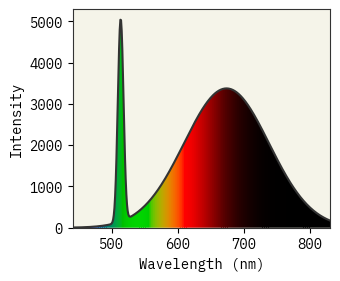

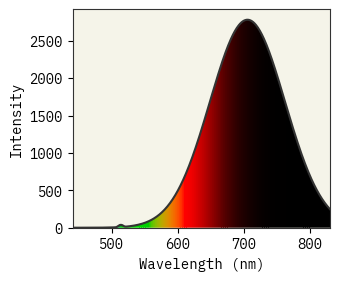

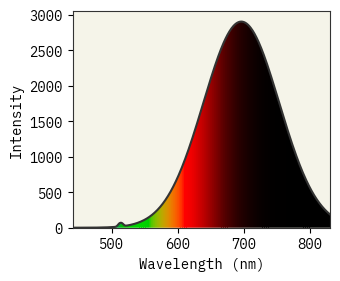

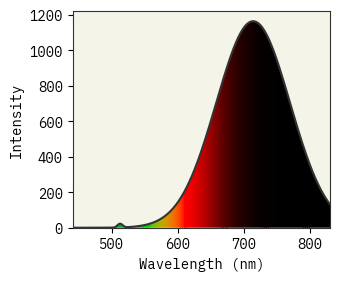

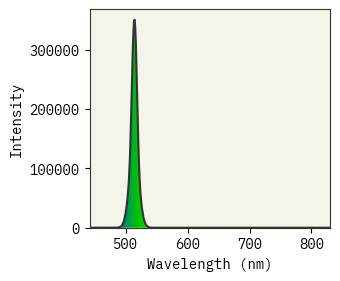

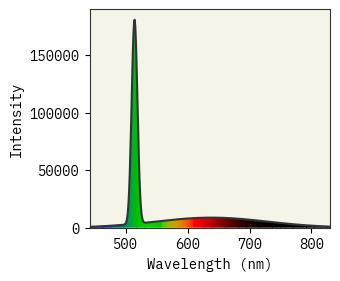

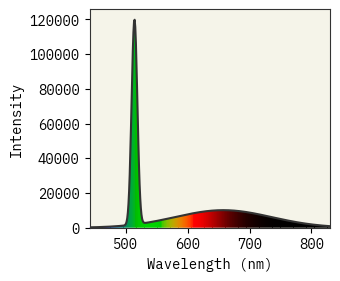

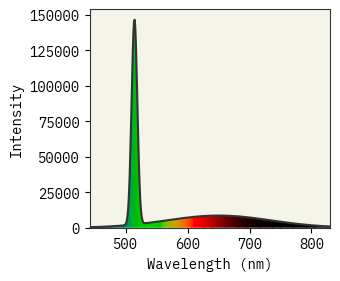

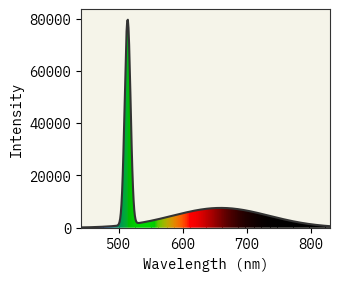

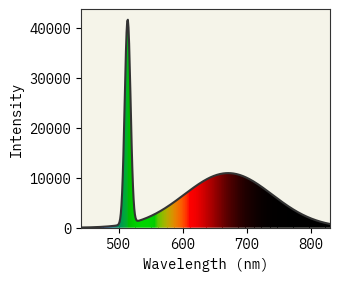

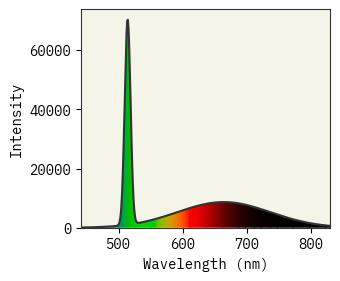

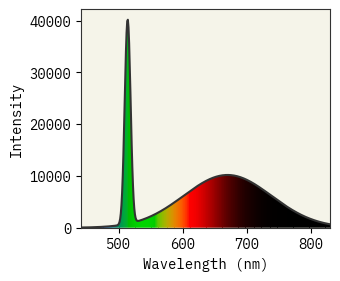

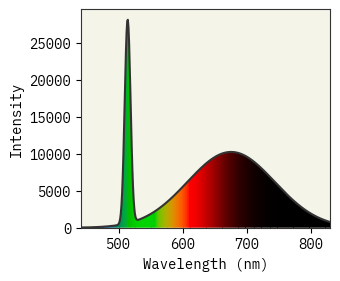

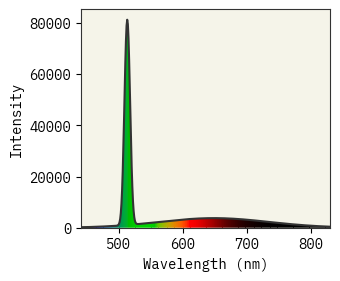

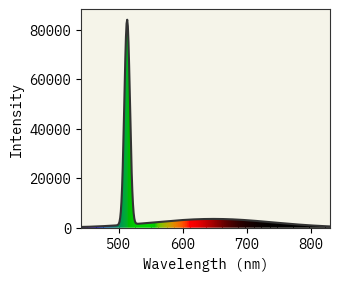

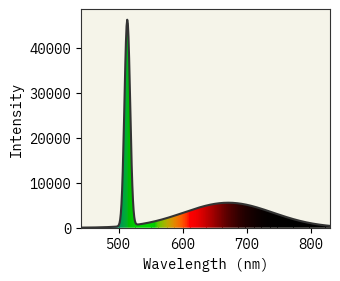

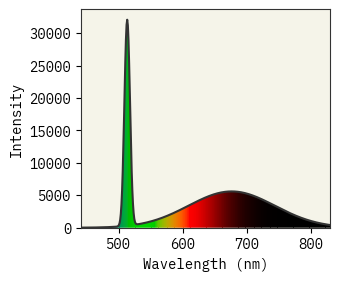

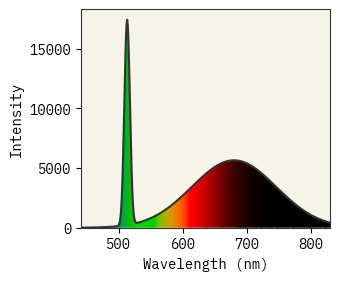

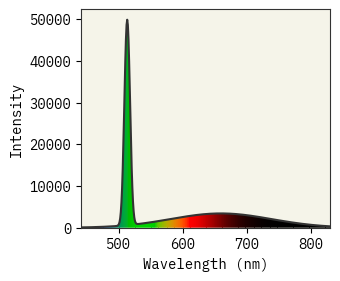

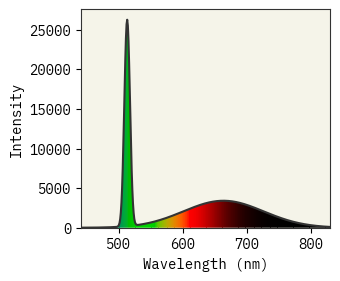

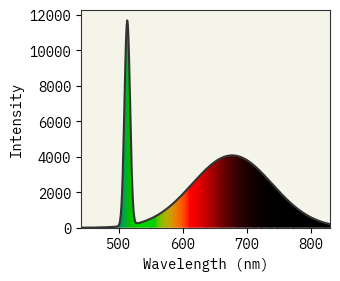

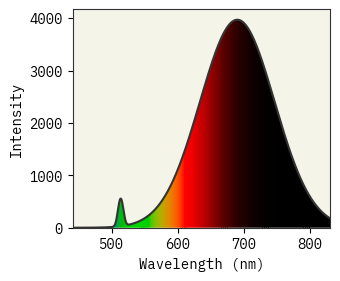

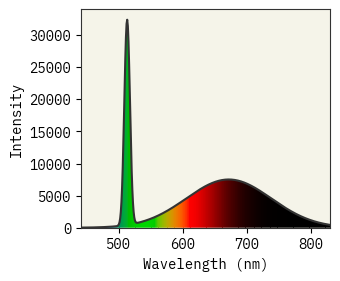

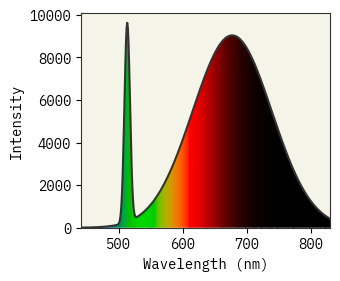

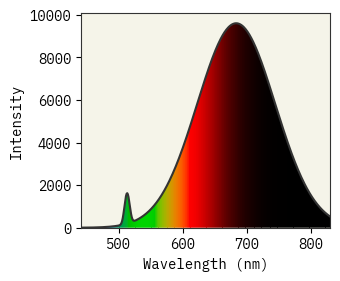

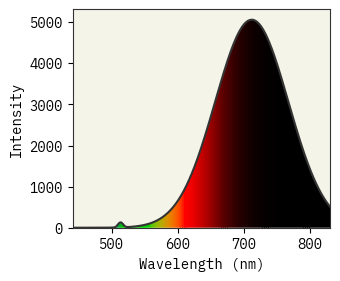

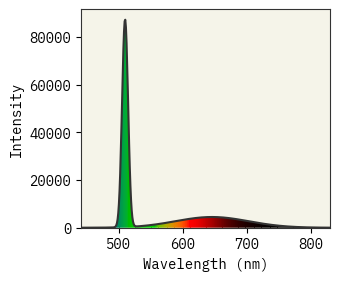

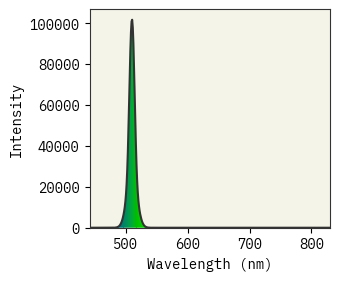

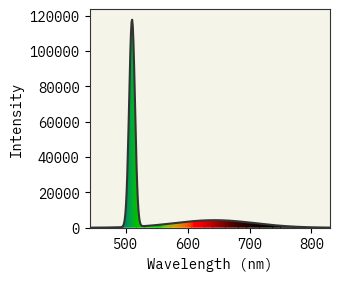

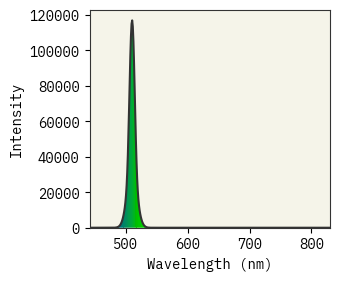

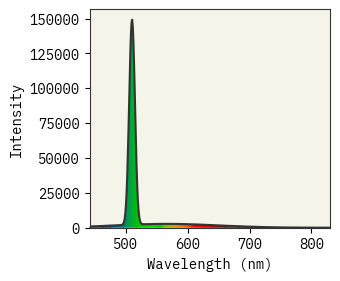

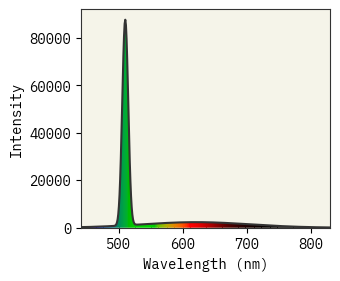

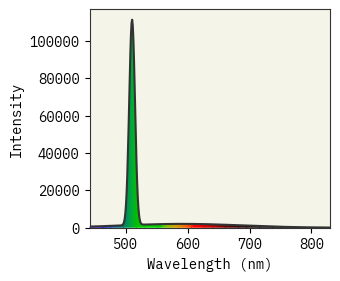

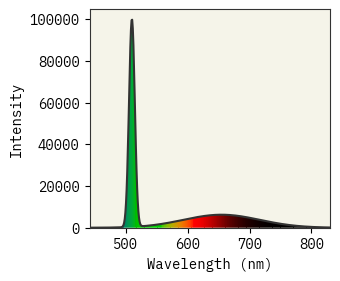

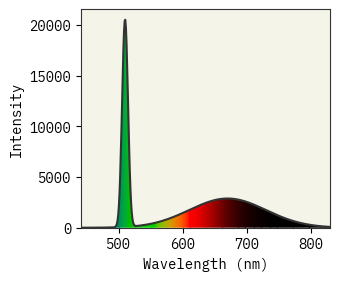

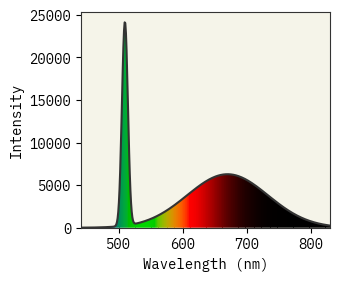

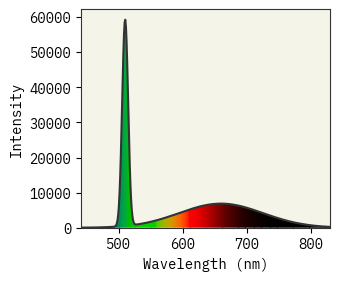

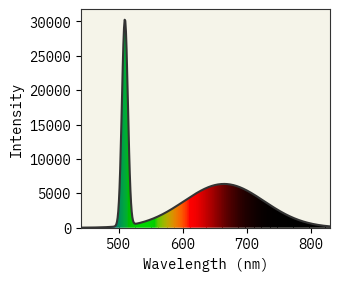

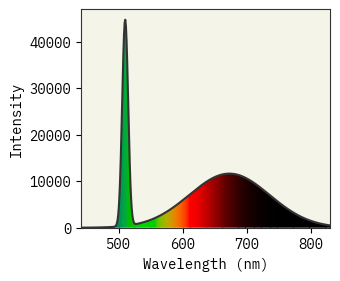

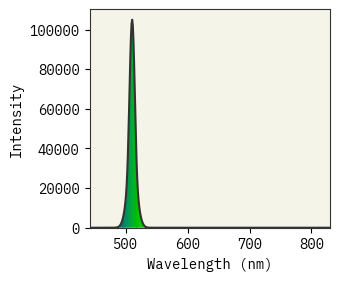

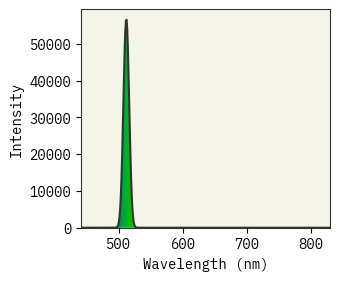

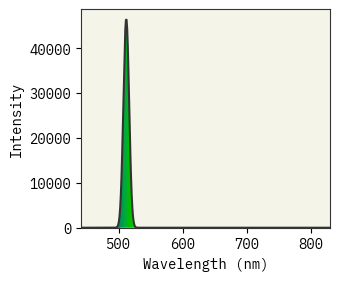

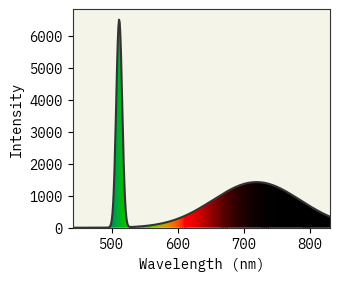

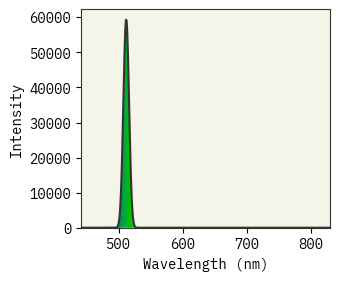

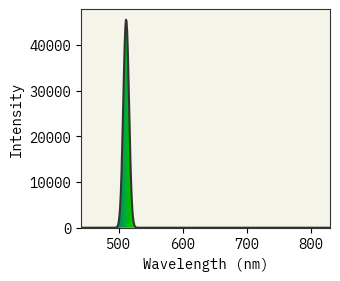

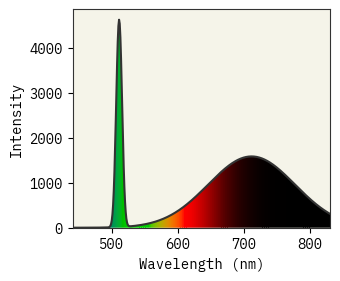

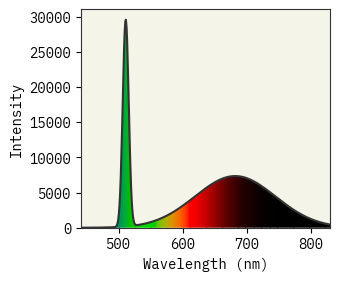

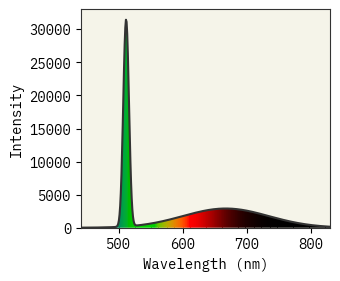

In [ ]:
import ast
df = pd.read_csv('Data/processed_datawobaseline.csv')


#Maintain only Dimension1(nm),Dimension2(nm),OD,Dilution(%),Nano_stock_vol(mL),Diluted_vol(mL),AgConc(M),AgMass(mg),MeOH_vol(mL),H2O_vol(mL),Doping(%),AgSol(uL),Time(min),Temperature(C),Experiment,
grouped = df.groupby(['Experiment','Doping(%)', 'Time(min)', 'Temperature(C)'])
features_labels_dict = {}

for name, group in grouped:
    features = group[['Dimension1(nm)', 'Dimension2(nm)', 'Dilution(%)', 'Nano_stock_vol(mL)', 
                      'Diluted_vol(mL)', 'AgConc(M)', 'AgMass(mg)', 'MeOH_vol(mL)', 
                      'H2O_vol(mL)', 'Doping(%)', 'AgSol(uL)', 'Time(min)', 
                      'Temperature(C)','Pre-QY','Fl_Wavelengths','Fluorescence']] #we can add more features here or remove some of them

    label = group['Area2']
    label2 = group['QY']

    features_labels_dict[name] = {'features': features, 'label': label, 'labelqy': label2}
group_keys = list(features_labels_dict.keys())

predictions = {}
# Get the group keys for training and testing
train_keys = [group_keys[i] for i in range(len(group_keys)) ]
test_keys = group_keys  # test_keys_index is a list with one elemen
# Prepare the training and testing data
train_features = np.vstack([features_labels_dict[key]['features'] for key in train_keys])
train_labels = np.hstack([features_labels_dict[key]['label'] for key in train_keys])
train_labels2 = np.hstack([features_labels_dict[key]['labelqy'] for key in train_keys])
#remove features whose pre-qy is -1

### add cofe here
pre_qy_not_minus_one_mask = [features_labels_dict[key]['features']['Pre-QY'] != -1 for key in train_keys]
# Apply this mask to train_features, train_labels, and train_labels2
train_features = np.vstack([features_labels_dict[key]['features'][pre_qy_not_minus_one_mask[idx]] for idx, key in enumerate(train_keys)])
train_labels = np.hstack([features_labels_dict[key]['label'][pre_qy_not_minus_one_mask[idx]] for idx, key in enumerate(train_keys)])
train_labels2 = np.hstack([features_labels_dict[key]['labelqy'][pre_qy_not_minus_one_mask[idx]] for idx, key in enumerate(train_keys)])


#remove data with -1 in QY for both qy and area2/ -1 is our flag for missing data
train_labels = train_labels[train_labels2 != -1]  
train_features = train_features[train_labels2 != -1]
train_labels2 = train_labels2[train_labels2 != -1]
if len(train_labels) == len(train_labels2)== len(train_features):
    train_final_label = train_labels * train_labels2
else:
     print("this is not working")

modified_features = train_features.copy()

for i in range(len(modified_features)):
    f_x = ast.literal_eval(modified_features[:,-2][i])
    f_y = ast.literal_eval(modified_features[:,-1][i])
    sd = get_sd_object(f_x, f_y)

    plot_single_sd(
        sd,
        # title='QY:0.8 | AUC2: 0.82 | F:0.65',
        title = f'{group_keys[i]} \n QY: {train_labels2[i]:.2f} | AUC2: {train_labels[i]:.2f} | F: {train_final_label[i]:.2f}',
        x_label='Wavelength (nm)',
        y_label='Intensity',
        axes_fontsize=30,
        figsize=(10, 5),
        )

    plt.show()
#plot with colour map

#only use the independent features
modified_features = modified_features[:,[0,1,2,3,5,6,9,11,12,13]] #TODO: Make it such that i can use the names for clarity.
#convert to tensor
#modified_features = torch.tensor(modified_features.values, dtype=torch.float)
#train_final_label = torch.tensor(train_final_label.values, dtype=torch.float)
#make sure to round up value up to two decimals
#save modified features and train_final_label to csv
df = pd.DataFrame(modified_features)
df['label'] = train_final_label
NAME_OF_FILE = 'Data/modified_featuresforBOwpreQY_corrected_final.csv'
# df.to_csv(NAME_OF_FILE)
# with open(f'{NAME_OF_FILE}_description_corr.txt', 'a') as f:
#     """Describe the columns of the modified features csv
#     and what are you changing or wanting to analyze from this dataset"""
#     description = """###ENTER DESCRIPTION HERE###
#     This dataset is corrected PL files. This dataset is similar to the original modified_features.csv, but it doesnt include pre-QY.
#     This is intended for a SR analysis with the pre-QY as an independent variable.
#     Same as begore, but the label is the normalized AUC2, the product of the area under the second peak and the QY.
#     """
#     f.write(f"Final_label,{train_final_label}\n")
#     f.write(description)

# #analysis of the data